# **Full Pipline for the Predicting the Winner of the match**

## **Importing the required Libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Step 2: EDA (skipped for brevity)

## **Data Loading**

In [3]:
# Step 1: Data Loading
def load_data():
    train_df = pd.read_csv(r'D:\Other Involment\Data Science\American_express_project_repo\American_Express_Project\Raw Data\663e2b6d54457_train_data_with_samplefeatures.csv')
    test_df = pd.read_csv(r'D:\Other Involment\Data Science\American_express_project_repo\American_Express_Project\Raw Data\6644a1e287df6_test_data_with_samplefeatures.csv')
    batsman_df = pd.read_csv(r'D:\Other Involment\Data Science\American_express_project_repo\American_Express_Project\Raw Data\663e2b548c98c_batsman_level_scorecard.csv')
    bowler_df = pd.read_csv(r'D:\Other Involment\Data Science\American_express_project_repo\American_Express_Project\Raw Data\663e2b2c60743_bowler_level_scorecard.csv')
    matchlevel_df= pd.read_csv(r'D:\Other Involment\Data Science\American_express_project_repo\American_Express_Project\Raw Data\664389efa0868_match_level_scorecard.csv')
    return train_df, test_df, batsman_df, bowler_df, matchlevel_df

In [4]:
train_df, test_df, batsman_df, bowler_df, matchlevel_df = load_data()

## **Preparing the Data**

### Converting IDs to object from int

In [5]:
# Function for converting the datatype of all columns' data points whose name is ending with id from int to string
def convert_id_to_string(df):
    for col in df.columns:
        if col.endswith('id'):
            df[col] = df[col].astype(str)
    return df

In [6]:
data= [train_df, test_df, batsman_df, bowler_df, matchlevel_df]
for df in data:
    df = convert_id_to_string(df)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   match_id                   948 non-null    object 
 1   team1                      948 non-null    object 
 2   team1_id                   948 non-null    object 
 3   team1_roster_ids           948 non-null    object 
 4   team2                      948 non-null    object 
 5   team2_id                   948 non-null    object 
 6   team2_roster_ids           948 non-null    object 
 7   winner                     948 non-null    object 
 8   winner_id                  948 non-null    object 
 9   toss winner                948 non-null    object 
 10  toss decision              948 non-null    object 
 11  venue                      948 non-null    object 
 12  city                       948 non-null    object 
 13  match_dt                   948 non-null    object 

In [8]:
# Create a new column 'team1_won' based on the condition
train_df['team1_won'] = np.where(train_df['winner_id'] == train_df['team1_id'], 1, 0)

In [9]:
train_df = train_df.drop(columns=['team1', 'team2','winner','lighting','series_name','season','venue'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   match_id                   948 non-null    object 
 1   team1_id                   948 non-null    object 
 2   team1_roster_ids           948 non-null    object 
 3   team2_id                   948 non-null    object 
 4   team2_roster_ids           948 non-null    object 
 5   winner_id                  948 non-null    object 
 6   toss winner                948 non-null    object 
 7   toss decision              948 non-null    object 
 8   city                       948 non-null    object 
 9   match_dt                   948 non-null    object 
 10  ground_id                  948 non-null    object 
 11  team_count_50runs_last15   948 non-null    float64
 12  team_winp_last5            948 non-null    float64
 13  team1only_avg_runs_last15  927 non-null    float64

In [10]:
test_df =test_df.drop(columns=['team1', 'team2','lighting','series_name','season','venue'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   match_id                   271 non-null    object 
 1   team1_id                   271 non-null    object 
 2   team1_roster_ids           271 non-null    object 
 3   team2_id                   271 non-null    object 
 4   team2_roster_ids           271 non-null    object 
 5   toss winner                271 non-null    object 
 6   toss decision              271 non-null    object 
 7   city                       271 non-null    object 
 8   match_dt                   271 non-null    object 
 9   ground_id                  271 non-null    object 
 10  team_count_50runs_last15   271 non-null    float64
 11  team_winp_last5            271 non-null    float64
 12  team1only_avg_runs_last15  264 non-null    float64
 13  team1_winp_team2_last15    271 non-null    float64

### Label Encoding on categorical attributes 

In [11]:
# Data Preprocessing
def preprocess_data(df):
    # Convert date columns to datetime
    df['match_dt'] = pd.to_datetime(df['match_dt'])
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in ['toss winner', 'toss decision','city']:
        df[col] = le.fit_transform(df[col])
    
    return df

In [12]:
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   match_id                   948 non-null    object        
 1   team1_id                   948 non-null    object        
 2   team1_roster_ids           948 non-null    object        
 3   team2_id                   948 non-null    object        
 4   team2_roster_ids           948 non-null    object        
 5   winner_id                  948 non-null    object        
 6   toss winner                948 non-null    int32         
 7   toss decision              948 non-null    int32         
 8   city                       948 non-null    int32         
 9   match_dt                   948 non-null    datetime64[ns]
 10  ground_id                  948 non-null    object        
 11  team_count_50runs_last15   948 non-null    float64       
 12  team_win

### Splitting the roasting id 

In [14]:
# Split roster IDs into individual columns
def split_roster_ids(df):
    max_players = 11  # Assuming maximum 11 players per team
    def convert_to_int(val):
        try:
            return int(float(val))
        except (ValueError, TypeError):
            return np.nan
    
    for i in range(max_players):
        df[f'team1_player_{i+1}'] = df['team1_roster_ids'].apply(lambda x: convert_to_int(x.split(':')[i]) if len(x.split(':')) > i else np.nan)
    for i in range(max_players):
        df[f'team2_player_{i+1}'] = df['team2_roster_ids'].apply(lambda x: convert_to_int(x.split(':')[i]) if len(x.split(':')) > i else np.nan)
    return df

In [15]:

train_df = split_roster_ids(train_df)
test_df = split_roster_ids(test_df)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   match_id                   948 non-null    object        
 1   team1_id                   948 non-null    object        
 2   team1_roster_ids           948 non-null    object        
 3   team2_id                   948 non-null    object        
 4   team2_roster_ids           948 non-null    object        
 5   winner_id                  948 non-null    object        
 6   toss winner                948 non-null    int32         
 7   toss decision              948 non-null    int32         
 8   city                       948 non-null    int32         
 9   match_dt                   948 non-null    datetime64[ns]
 10  ground_id                  948 non-null    object        
 11  team_count_50runs_last15   948 non-null    float64       
 12  team_win

In [17]:
test_df.head()

,match_id,team1_id,team1_roster_ids,team2_id,team2_roster_ids,toss winner,toss decision,city,match_dt,ground_id,...,team2_player_2,team2_player_3,team2_player_4,team2_player_5,team2_player_6,team2_player_7,team2_player_8,team2_player_9,team2_player_10,team2_player_11
0,9250275,28594,7438955.0:8271969.0:8369661.0:3685247.0:259025...,90,2436944.0:8117500.0:6703528.0:3010748.0:161387...,104,1,13,2022-07-11,3226,...,8117500,6703528,3010748,1613870,8934764,2721480,1632819,2789604,6489846,1565507
1,9262189,36084,3715690.0:6818622.0:4069666.0:393014.0:4690188...,36098,4690258.0:3761246.0:8464385.0:5742470.0:315072...,40,1,70,2022-09-21,13915,...,3761246,8464385,5742470,3150720,4690104,181404,1594319,5509524,4239794,2036649
2,9128776,30428,8058959.0:2162782.0:2981614.0:7833195.0:755605...,48334,2654014.0:2954769.0:8058903.0:3479860.0:329940...,82,0,58,2022-05-15,2764,...,2954769,8058903,3479860,3299407,2275097,2740408,3865077,7924048,4859490,8228100
3,9586919,36098,4690258.0:8464385.0:1613898.0:5744780.0:315072...,36112,2331475.0:313809.0:391103.0:2742837.0:2097017....,92,1,38,2023-08-16,11892,...,313809,391103,2742837,2097017,7921535,7459647,8464343,4690230,8339701,4702774
4,9128538,30414,7422673.0:249087.0:62432.0:232000.0:5001170.0:...,48341,1958683.0:7491224.0:3339160.0:5452754.0:225245...,31,1,71,2022-04-17,18752,...,7491224,3339160,5452754,2252452,2966879,5554254,4690230,3456424,3373285,8118053


In [18]:
def convert_to_object(df, columns):
    for column in columns:
        df[column] = df[column].astype(str)
    return df

# Assuming the DataFrame is named df
columns_to_convert = [
    'team1_player_1', 'team2_player_1', 'team1_player_2', 'team2_player_2',
    'team1_player_3', 'team2_player_3', 'team1_player_4', 'team2_player_4',
    'team1_player_5', 'team2_player_5', 'team1_player_6', 'team2_player_6',
    'team1_player_7', 'team2_player_7', 'team1_player_8', 'team2_player_8',
    'team1_player_9', 'team2_player_9', 'team1_player_10', 'team2_player_10',
    'team1_player_11', 'team2_player_11'
]

# Convert the specified columns to object type
train_df = convert_to_object(train_df, columns_to_convert)
test_df = convert_to_object(test_df, columns_to_convert)

In [19]:
# rearrange =[
#     'team1_player_1', 'team1_player_2',
#     'team1_player_3', 'team1_player_4',
#     'team1_player_5',  'team1_player_6', 
#     'team1_player_7',  'team1_player_8', 
#     'team1_player_9',  'team1_player_10', 
#     'team1_player_11', 'team2_player_1',
#     'team2_player_2', 'team2_player_3', 
#     'team2_player_4','team2_player_5',
#     'team2_player_6','team2_player_7',
#     'team2_player_8','team2_player_9',
#     'team2_player_10', 'team2_player_11'
# ]

In [20]:
train_df, test_df= train_df.drop(columns=['team1_roster_ids','team2_roster_ids','city']), test_df.drop(columns=['team1_roster_ids','team2_roster_ids','city'])

In [21]:
train_df.head()

,match_id,team1_id,team2_id,winner_id,toss winner,toss decision,match_dt,ground_id,team_count_50runs_last15,team_winp_last5,...,team2_player_2,team2_player_3,team2_player_4,team2_player_5,team2_player_6,team2_player_7,team2_player_8,team2_player_9,team2_player_10,team2_player_11
0,9331181,11283,12634,12634,44,1,2022-10-20,7398,1.666667,0.672131,...,4231751,2735081,2035102,3698337,5058192,6844718,4566526,6596582,4161975,7952804
1,8797060,20,41,20,138,1,2022-01-23,1406,1.285714,1.952381,...,4069666,4230127,1942317,1613926,2740408,4739552,5744850,4690104,3715697,3468870
2,9433269,10576,8987,10576,81,1,2023-06-02,251,0.857143,0.672131,...,1749075,1626526,4172447,5516720,7328110,125915,130437,7507303,4420828,5652828
3,9587073,36084,36070,36084,34,0,2023-09-10,14300,2.166667,1.975610,...,2436405,1798705,7550857,5742470,2740408,3575774,3200756,334963,6399210,6347494
4,9516457,30407,48341,48341,40,1,2023-04-13,7118,0.818182,1.327869,...,7491224,8059029,4377610,2252452,2966879,5554254,4690230,3373285,3759846,6496482


In [22]:
test_df.head()

,match_id,team1_id,team2_id,toss winner,toss decision,match_dt,ground_id,team_count_50runs_last15,team_winp_last5,team1only_avg_runs_last15,...,team2_player_2,team2_player_3,team2_player_4,team2_player_5,team2_player_6,team2_player_7,team2_player_8,team2_player_9,team2_player_10,team2_player_11
0,9250275,28594,90,104,1,2022-07-11,3226,0.000000,0.019608,NaN,...,8117500,6703528,3010748,1613870,8934764,2721480,1632819,2789604,6489846,1565507
1,9262189,36084,36098,40,1,2022-09-21,13915,0.615385,0.344262,151.285714,...,3761246,8464385,5742470,3150720,4690104,181404,1594319,5509524,4239794,2036649
2,9128776,30428,48334,82,0,2022-05-15,2764,0.842105,0.753086,171.066667,...,2954769,8058903,3479860,3299407,2275097,2740408,3865077,7924048,4859490,8228100
3,9586919,36098,36112,92,1,2023-08-16,11892,0.285714,1.487805,166.000000,...,313809,391103,2742837,2097017,7921535,7459647,8464343,4690230,8339701,4702774
4,9128538,30414,48341,31,1,2022-04-17,18752,2.375000,0.310330,169.933333,...,7491224,3339160,5452754,2252452,2966879,5554254,4690230,3456424,3373285,8118053


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   match_id                   948 non-null    object        
 1   team1_id                   948 non-null    object        
 2   team2_id                   948 non-null    object        
 3   winner_id                  948 non-null    object        
 4   toss winner                948 non-null    int32         
 5   toss decision              948 non-null    int32         
 6   match_dt                   948 non-null    datetime64[ns]
 7   ground_id                  948 non-null    object        
 8   team_count_50runs_last15   948 non-null    float64       
 9   team_winp_last5            948 non-null    float64       
 10  team1only_avg_runs_last15  927 non-null    float64       
 11  team1_winp_team2_last15    948 non-null    float64       
 12  ground_a

### Imputing in numerical Attributes

In [24]:
# Finding number of null values in the column ground_avg_runs_last15 and team1only_avg_runs_last15  
print(train_df['ground_avg_runs_last15'].isnull().sum())
print(train_df['team1only_avg_runs_last15'].isnull().sum())

53
21


In [25]:
def impute_numerical_columns(df, method='mean'):

    numerical_cols = df.select_dtypes(include=[np.number]).columns

    for col in numerical_cols:
        if method == 'mean':
            impute_value = df[col].mean()
        elif method == 'median':
            impute_value = df[col].median()
        else:
            raise ValueError("Method must be either 'mean' or 'median'")

        df[col].fillna(impute_value, inplace=True)

    return df

# Example usage for training and test datasets
train_df = impute_numerical_columns(train_df, method='mean')
test_df = impute_numerical_columns(test_df, method='mean')

### Outliers Handling

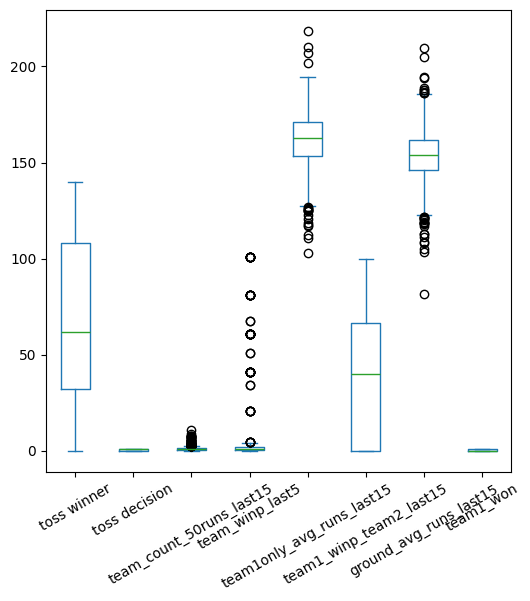

In [26]:
import matplotlib.pyplot as plt
train_df.plot(kind= 'box',figsize= (6,6), fontsize=10)
plt.xticks(rotation=30);

In [27]:
# Function to remove outliers based on IQR method
def remove_outliers(df):
    # Get the numerical columns in the DataFrame
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    for col in numerical_cols:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile) for the column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 3.5 * IQR
        upper_bound = Q3 + 3.5 * IQR
        
        # Filter out the outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        # outlier = df[(df[col]<= lower_bound) | (df[col] >= upper_bound )] 
        
    
    return df


In [28]:
train_df = remove_outliers(train_df)
test_df =remove_outliers(test_df)
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 0 to 946
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   match_id                   875 non-null    object        
 1   team1_id                   875 non-null    object        
 2   team2_id                   875 non-null    object        
 3   winner_id                  875 non-null    object        
 4   toss winner                875 non-null    int32         
 5   toss decision              875 non-null    int32         
 6   match_dt                   875 non-null    datetime64[ns]
 7   ground_id                  875 non-null    object        
 8   team_count_50runs_last15   875 non-null    float64       
 9   team_winp_last5            875 non-null    float64       
 10  team1only_avg_runs_last15  875 non-null    float64       
 11  team1_winp_team2_last15    875 non-null    float64       
 12  ground_a

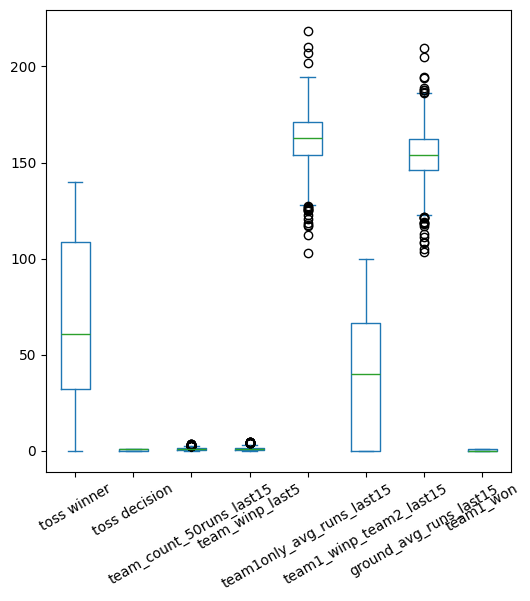

In [29]:
import matplotlib.pyplot as plt
train_df.plot(kind= 'box',figsize= (6,6), fontsize=10)
plt.xticks(rotation=30);

### **Features Data Preperation**

In [30]:
batsman_df.head()

,match_id,batsman,batsman_id,batsman_details,is_batsman_captain,is_batsman_keeper,inning,runs,balls_faced,over_faced_first,...,out_by_bowler,out_by_fielder,bowler_id,bowler_details,is_bowler_keeper,is_bowler_captain,strike_rate,Fours,Sixes,match_dt
0,8638034,KD Ce,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,7,5,1.1,...,JS Nm,TM Jn,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,140.00,1.0,NaN,2021-01-01
1,8638034,TL St,4381761.0,NZ:Right-hand bat:None:,0.0,1.0,1,46,46,1.2,...,R Ra,MG Bl,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,0.0,0.0,100.00,4.0,1.0,2021-01-01
2,8638034,HR Cr,4949790.0,NZ:Right-hand bat:Right-arm offbreak:,0.0,0.0,1,9,10,12.1,...,PF Yd,R Ra,4950294.0,NZ:Right-hand bat:Legbreak googly:,0.0,0.0,90.00,NaN,NaN,2021-01-01
3,8638034,BR Hn,3834305.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,28,22,13.6,...,HK Bt,FH An,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,127.27,3.0,NaN,2021-01-01
4,8638034,SC Kn,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,0.0,0.0,1,18,13,17.2,...,NaN,None,nan,NaN,NaN,NaN,138.46,NaN,1.0,2021-01-01


In [31]:
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24483 entries, 0 to 24482
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            24483 non-null  object 
 1   batsman             24483 non-null  object 
 2   batsman_id          24483 non-null  object 
 3   batsman_details     24483 non-null  object 
 4   is_batsman_captain  24483 non-null  float64
 5   is_batsman_keeper   24483 non-null  float64
 6   inning              24483 non-null  int64  
 7   runs                24483 non-null  int64  
 8   balls_faced         24483 non-null  int64  
 9   over_faced_first    24483 non-null  float64
 10  wicket kind         19155 non-null  object 
 11  out_by_bowler       19155 non-null  object 
 12  out_by_fielder      24483 non-null  object 
 13  bowler_id           24483 non-null  object 
 14  bowler_details      18128 non-null  object 
 15  is_bowler_keeper    18698 non-null  float64
 16  is_b

In [32]:
col_drop = ['batsman','is_batsman_captain','is_batsman_keeper','out_by_bowler','out_by_fielder','wicket kind','is_bowler_keeper','is_bowler_captain']
batsman_df= batsman_df.drop(columns=col_drop)
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24483 entries, 0 to 24482
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_id          24483 non-null  object 
 1   batsman_id        24483 non-null  object 
 2   batsman_details   24483 non-null  object 
 3   inning            24483 non-null  int64  
 4   runs              24483 non-null  int64  
 5   balls_faced       24483 non-null  int64  
 6   over_faced_first  24483 non-null  float64
 7   bowler_id         24483 non-null  object 
 8   bowler_details    18128 non-null  object 
 9   strike_rate       24474 non-null  float64
 10  Fours             14200 non-null  float64
 11  Sixes             8994 non-null   float64
 12  match_dt          24483 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 2.4+ MB


In [33]:
# Assuming the DataFrame is named df
def impute_strike_rate(df):
    # Calculate the average strike rate for each batsman
    batsman_avg_strike_rate = df.groupby('batsman_id')['strike_rate'].mean()

    # Function to impute strike rate with the batsman's average
    def impute(row):
        if pd.isna(row['strike_rate']):
            return batsman_avg_strike_rate.get(row['batsman_id'], np.nan)
        return row['strike_rate']

    # Apply the imputation function
    df['strike_rate'] = df.apply(impute, axis=1)
    
    return df

In [34]:
# Impute the strike_rate column
batsman_df= impute_strike_rate(batsman_df)
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24483 entries, 0 to 24482
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_id          24483 non-null  object 
 1   batsman_id        24483 non-null  object 
 2   batsman_details   24483 non-null  object 
 3   inning            24483 non-null  int64  
 4   runs              24483 non-null  int64  
 5   balls_faced       24483 non-null  int64  
 6   over_faced_first  24483 non-null  float64
 7   bowler_id         24483 non-null  object 
 8   bowler_details    18128 non-null  object 
 9   strike_rate       24483 non-null  float64
 10  Fours             14200 non-null  float64
 11  Sixes             8994 non-null   float64
 12  match_dt          24483 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 2.4+ MB


In [35]:
from sklearn.linear_model import LinearRegression

# Imputation funtion for the fours and sixes using Linear regression
def impute_missing_values(df):
    
    # Helper function to train a regression model and predict missing values
    def impute_column(column_name, features):
        
        # Separate the data into training and predicting sets
        df_train = df[df[column_name].notnull()]
        df_predict = df[df[column_name].isnull()]

        X_train = df_train[features]
        y_train = df_train[column_name]
        
        if df_predict.empty:
            return df
        
        X_predict = df_predict[features]
        
        # Train the model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict the missing values
        df.loc[df[column_name].isnull(), column_name] = model.predict(X_predict)
        return df

    # List of features to use for imputation
    features = ['strike_rate', 'balls_faced', 'runs', 'inning']
    
    # Impute 'Fours' and 'Sixes'
    df = impute_column('Fours', features)
    df = impute_column('Sixes', features)
    
    return df



In [36]:
# Assuming the DataFrame is named df
batsman_df = impute_missing_values(batsman_df)
batsman_df.head()


,match_id,batsman_id,batsman_details,inning,runs,balls_faced,over_faced_first,bowler_id,bowler_details,strike_rate,Fours,Sixes,match_dt
0,8638034,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,1,7,5,1.1,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,140.00,1.000000,0.944766,2021-01-01
1,8638034,4381761.0,NZ:Right-hand bat:None:,1,46,46,1.2,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,100.00,4.000000,1.000000,2021-01-01
2,8638034,4949790.0,NZ:Right-hand bat:Right-arm offbreak:,1,9,10,12.1,4950294.0,NZ:Right-hand bat:Legbreak googly:,90.00,1.170689,0.727082,2021-01-01
3,8638034,3834305.0,NZ:Right-hand bat:Right-arm medium-fast:,1,28,22,13.6,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,127.27,3.000000,1.399349,2021-01-01
4,8638034,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,1,18,13,17.2,nan,NaN,138.46,1.895936,1.000000,2021-01-01


In [37]:
def fillna_df(df,column_name,fill_value):
    df[column_name] = df[column_name].fillna(fill_value)
    return df



In [38]:
fill = 'None:None:None:'
batsman_df = fillna_df(batsman_df,'bowler_details', fill)
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24483 entries, 0 to 24482
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_id          24483 non-null  object 
 1   batsman_id        24483 non-null  object 
 2   batsman_details   24483 non-null  object 
 3   inning            24483 non-null  int64  
 4   runs              24483 non-null  int64  
 5   balls_faced       24483 non-null  int64  
 6   over_faced_first  24483 non-null  float64
 7   bowler_id         24483 non-null  object 
 8   bowler_details    24483 non-null  object 
 9   strike_rate       24483 non-null  float64
 10  Fours             24483 non-null  float64
 11  Sixes             24483 non-null  float64
 12  match_dt          24483 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 2.4+ MB


In [39]:
batsman_df.head()

,match_id,batsman_id,batsman_details,inning,runs,balls_faced,over_faced_first,bowler_id,bowler_details,strike_rate,Fours,Sixes,match_dt
0,8638034,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,1,7,5,1.1,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,140.00,1.000000,0.944766,2021-01-01
1,8638034,4381761.0,NZ:Right-hand bat:None:,1,46,46,1.2,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,100.00,4.000000,1.000000,2021-01-01
2,8638034,4949790.0,NZ:Right-hand bat:Right-arm offbreak:,1,9,10,12.1,4950294.0,NZ:Right-hand bat:Legbreak googly:,90.00,1.170689,0.727082,2021-01-01
3,8638034,3834305.0,NZ:Right-hand bat:Right-arm medium-fast:,1,28,22,13.6,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,127.27,3.000000,1.399349,2021-01-01
4,8638034,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,1,18,13,17.2,nan,None:None:None:,138.46,1.895936,1.000000,2021-01-01


In [40]:
def round_column_values(df, column_name, decimals=0):
    for col in column_name:
        df[column_name] = df[column_name].round(decimals)
    return df


In [41]:
col_round =['Fours','Sixes']
batsman_df= round_column_values(batsman_df,col_round,0)
batsman_df

,match_id,batsman_id,batsman_details,inning,runs,balls_faced,over_faced_first,bowler_id,bowler_details,strike_rate,Fours,Sixes,match_dt
0,8638034,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,1,7,5,1.1,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,140.00,1.0,1.0,2021-01-01
1,8638034,4381761.0,NZ:Right-hand bat:None:,1,46,46,1.2,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,100.00,4.0,1.0,2021-01-01
2,8638034,4949790.0,NZ:Right-hand bat:Right-arm offbreak:,1,9,10,12.1,4950294.0,NZ:Right-hand bat:Legbreak googly:,90.00,1.0,1.0,2021-01-01
3,8638034,3834305.0,NZ:Right-hand bat:Right-arm medium-fast:,1,28,22,13.6,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,127.27,3.0,1.0,2021-01-01
4,8638034,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,1,18,13,17.2,nan,None:None:None:,138.46,2.0,1.0,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24478,9433633,2173688.0,ENG:Right-hand bat:Left-arm medium-fast:,1,1,1,20.4,nan,None:None:None:,100.00,1.0,1.0,2023-06-20
24479,9433633,5241564.0,ENG:Right-hand bat:Right-arm offbreak:,1,37,28,6.6,1707628.0,ENG:Right-hand bat:Slow left-arm orthodox:,132.14,4.0,1.0,2023-06-20
24480,9433633,4898074.0,SA:Right-hand bat:None:,2,1,6,1.1,8833075.0,ENG:Right-hand bat:Right-arm fast-medium:,16.67,1.0,0.0,2023-06-20
24481,9433633,8048074.0,ENG:Right-hand bat:None:,2,43,22,2.3,nan,None:None:None:,195.45,3.0,3.0,2023-06-20


In [42]:
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24483 entries, 0 to 24482
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   match_id          24483 non-null  object 
 1   batsman_id        24483 non-null  object 
 2   batsman_details   24483 non-null  object 
 3   inning            24483 non-null  int64  
 4   runs              24483 non-null  int64  
 5   balls_faced       24483 non-null  int64  
 6   over_faced_first  24483 non-null  float64
 7   bowler_id         24483 non-null  object 
 8   bowler_details    24483 non-null  object 
 9   strike_rate       24483 non-null  float64
 10  Fours             24483 non-null  float64
 11  Sixes             24483 non-null  float64
 12  match_dt          24483 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 2.4+ MB


In [43]:
def split_column_values(df, column, new_column_names, delimiter=':'):

    # Split the column values
    split_columns = df[column].str.split(delimiter, expand=True)
    
    # Rename the new columns
    split_columns.columns = new_column_names
    
    # Concatenate the new columns with the original DataFrame
    df = pd.concat([df, split_columns], axis=1)
    
    return df

# Example usage:
# Assuming the DataFrame is named df and the column to split is 'batsman_details'
new_column_names = ['country_bat', 'batting_style_bat', 'bowling_style_bat','space']
batsman_df = split_column_values(batsman_df, 'batsman_details', new_column_names)



In [44]:
new_column_names_ = ['country_bowl', 'batting_style_bowl', 'bowling_style_bowl','space']
batsman_df= split_column_values(batsman_df, 'bowler_details', new_column_names_)
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24483 entries, 0 to 24482
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            24483 non-null  object 
 1   batsman_id          24483 non-null  object 
 2   batsman_details     24483 non-null  object 
 3   inning              24483 non-null  int64  
 4   runs                24483 non-null  int64  
 5   balls_faced         24483 non-null  int64  
 6   over_faced_first    24483 non-null  float64
 7   bowler_id           24483 non-null  object 
 8   bowler_details      24483 non-null  object 
 9   strike_rate         24483 non-null  float64
 10  Fours               24483 non-null  float64
 11  Sixes               24483 non-null  float64
 12  match_dt            24483 non-null  object 
 13  country_bat         24483 non-null  object 
 14  batting_style_bat   24483 non-null  object 
 15  bowling_style_bat   24483 non-null  object 
 16  spac

In [45]:
batsman_df.head()

,match_id,batsman_id,batsman_details,inning,runs,balls_faced,over_faced_first,bowler_id,bowler_details,strike_rate,...,Sixes,match_dt,country_bat,batting_style_bat,bowling_style_bat,space,country_bowl,batting_style_bowl,bowling_style_bowl,space
0,8638034,7907451.0,NZ:Right-hand bat:Right-arm medium-fast:,1,7,5,1.1,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,140.00,...,1.0,2021-01-01,NZ,Right-hand bat,Right-arm medium-fast,,NZ,Left-hand bat,Right-arm medium-fast,
1,8638034,4381761.0,NZ:Right-hand bat:None:,1,46,46,1.2,6718382.0,NZ:Left-hand bat:Slow left-arm orthodox:,100.00,...,1.0,2021-01-01,NZ,Right-hand bat,None,,NZ,Left-hand bat,Slow left-arm orthodox,
2,8638034,4949790.0,NZ:Right-hand bat:Right-arm offbreak:,1,9,10,12.1,4950294.0,NZ:Right-hand bat:Legbreak googly:,90.00,...,1.0,2021-01-01,NZ,Right-hand bat,Right-arm offbreak,,NZ,Right-hand bat,Legbreak googly,
3,8638034,3834305.0,NZ:Right-hand bat:Right-arm medium-fast:,1,28,22,13.6,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,127.27,...,1.0,2021-01-01,NZ,Right-hand bat,Right-arm medium-fast,,NZ,Left-hand bat,Right-arm medium-fast,
4,8638034,3776849.0,NZ:Right-hand bat:Right-arm fast-medium:,1,18,13,17.2,nan,None:None:None:,138.46,...,1.0,2021-01-01,NZ,Right-hand bat,Right-arm fast-medium,,None,None,None,


In [46]:
batsman_df = batsman_df.drop(columns=['space','batsman_details','bowler_details'])
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24483 entries, 0 to 24482
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            24483 non-null  object 
 1   batsman_id          24483 non-null  object 
 2   inning              24483 non-null  int64  
 3   runs                24483 non-null  int64  
 4   balls_faced         24483 non-null  int64  
 5   over_faced_first    24483 non-null  float64
 6   bowler_id           24483 non-null  object 
 7   strike_rate         24483 non-null  float64
 8   Fours               24483 non-null  float64
 9   Sixes               24483 non-null  float64
 10  match_dt            24483 non-null  object 
 11  country_bat         24483 non-null  object 
 12  batting_style_bat   24483 non-null  object 
 13  bowling_style_bat   24483 non-null  object 
 14  country_bowl        24483 non-null  object 
 15  batting_style_bowl  24483 non-null  object 
 16  bowl

### **Calculated Batsman Rating**


In [47]:
import pandas as pd
import numpy as np

def calculate_batsman_rating(batsman_df):
    # Convert match_dt to datetime
    batsman_df['match_dt'] = pd.to_datetime(batsman_df['match_dt'])
    
    # Get the current date for calculating recency
    current_date = batsman_df['match_dt'].max()
    
    # Filter last 7 matches for each batsman
    recent_matches = batsman_df[batsman_df['match_dt'] >= current_date - pd.DateOffset(weeks=7)]
    
    # Calculate recent performance metrics
    recent_performance = recent_matches.groupby('batsman_id').agg({
        'runs': 'sum',
        'balls_faced': 'sum',
        'strike_rate': 'mean',
        'Fours': 'sum',
        'Sixes': 'sum'
    }).reset_index()
    
    # Calculate overall performance metrics
    overall_performance = batsman_df.groupby('batsman_id').agg({
        'runs': 'sum',
        'balls_faced': 'sum',
        'strike_rate': 'mean',
        'Fours': 'sum',
        'Sixes': 'sum'
    }).reset_index()
    
    # Merge recent and overall performance
    performance = pd.merge(overall_performance, recent_performance, on='batsman_id', suffixes=('_overall', '_recent'))
    
    # Calculate ratings
    performance['recent_runs'] = performance['runs_recent'] / (performance['balls_faced_recent'] + 1)
    performance['recent_strike_rate'] = performance['strike_rate_recent']
    performance['recent_fours'] = performance['Fours_recent'] / (performance['balls_faced_recent'] + 1)
    performance['recent_sixes'] = performance['Sixes_recent'] / (performance['balls_faced_recent'] + 1)
    
    performance['overall_runs'] = performance['runs_overall'] / (performance['balls_faced_overall'] + 1)
    performance['overall_strike_rate'] = performance['strike_rate_overall']
    performance['overall_fours'] = performance['Fours_overall'] / (performance['balls_faced_overall'] + 1)
    performance['overall_sixes'] = performance['Sixes_overall'] / (performance['balls_faced_overall'] + 1)
    
    # Calculate final rating based on weighted metrics
    performance['batsman_rating'] = (0.3 * performance['recent_runs'] + 
                             0.25 * performance['recent_strike_rate'] + 
                             0.2 * performance['recent_fours'] + 
                             0.15 * performance['recent_sixes'] + 
                             0.1 * performance['overall_runs'] +
                             0.1 * performance['overall_strike_rate'] +
                             0.05 * performance['overall_fours'] +
                             0.05 * performance['overall_sixes'])
    
    return performance[['batsman_id', 'batsman_rating']]

In [48]:
# Example usage
# batsman_df = pd.read_csv('batsman_data.csv')  # replace with actual data loading
batsman_ratings = calculate_batsman_rating(batsman_df)
batsman_ratings.sort_values(by='batsman_rating',ascending=False)

,batsman_id,batsman_rating
162,4992378.0,98.231958
67,2740408.0,84.026574
314,9883250.0,77.808333
200,6364588.0,76.121482
313,9874052.0,74.376190
...,...,...
218,6819238.0,1.779778
299,8964675.0,0.225000
309,9395175.0,0.225000
305,9059021.0,0.225000


In [49]:
batsman_df= batsman_df.merge(batsman_ratings, on='batsman_id')
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8151 entries, 0 to 8150
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   match_id            8151 non-null   object        
 1   batsman_id          8151 non-null   object        
 2   inning              8151 non-null   int64         
 3   runs                8151 non-null   int64         
 4   balls_faced         8151 non-null   int64         
 5   over_faced_first    8151 non-null   float64       
 6   bowler_id           8151 non-null   object        
 7   strike_rate         8151 non-null   float64       
 8   Fours               8151 non-null   float64       
 9   Sixes               8151 non-null   float64       
 10  match_dt            8151 non-null   datetime64[ns]
 11  country_bat         8151 non-null   object        
 12  batting_style_bat   8151 non-null   object        
 13  bowling_style_bat   8151 non-null   object      

### Distribution Plots

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot distribution of strike_rate
def plot_distribution(df):
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns
    
    # Set up the matplotlib figure
    plt.figure(figsize=(15, len(numerical_columns) * 4))
    
    # Plot each numerical column
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(len(numerical_columns), 1, i)
        sns.histplot(df[column].dropna(), kde=True, bins=30)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


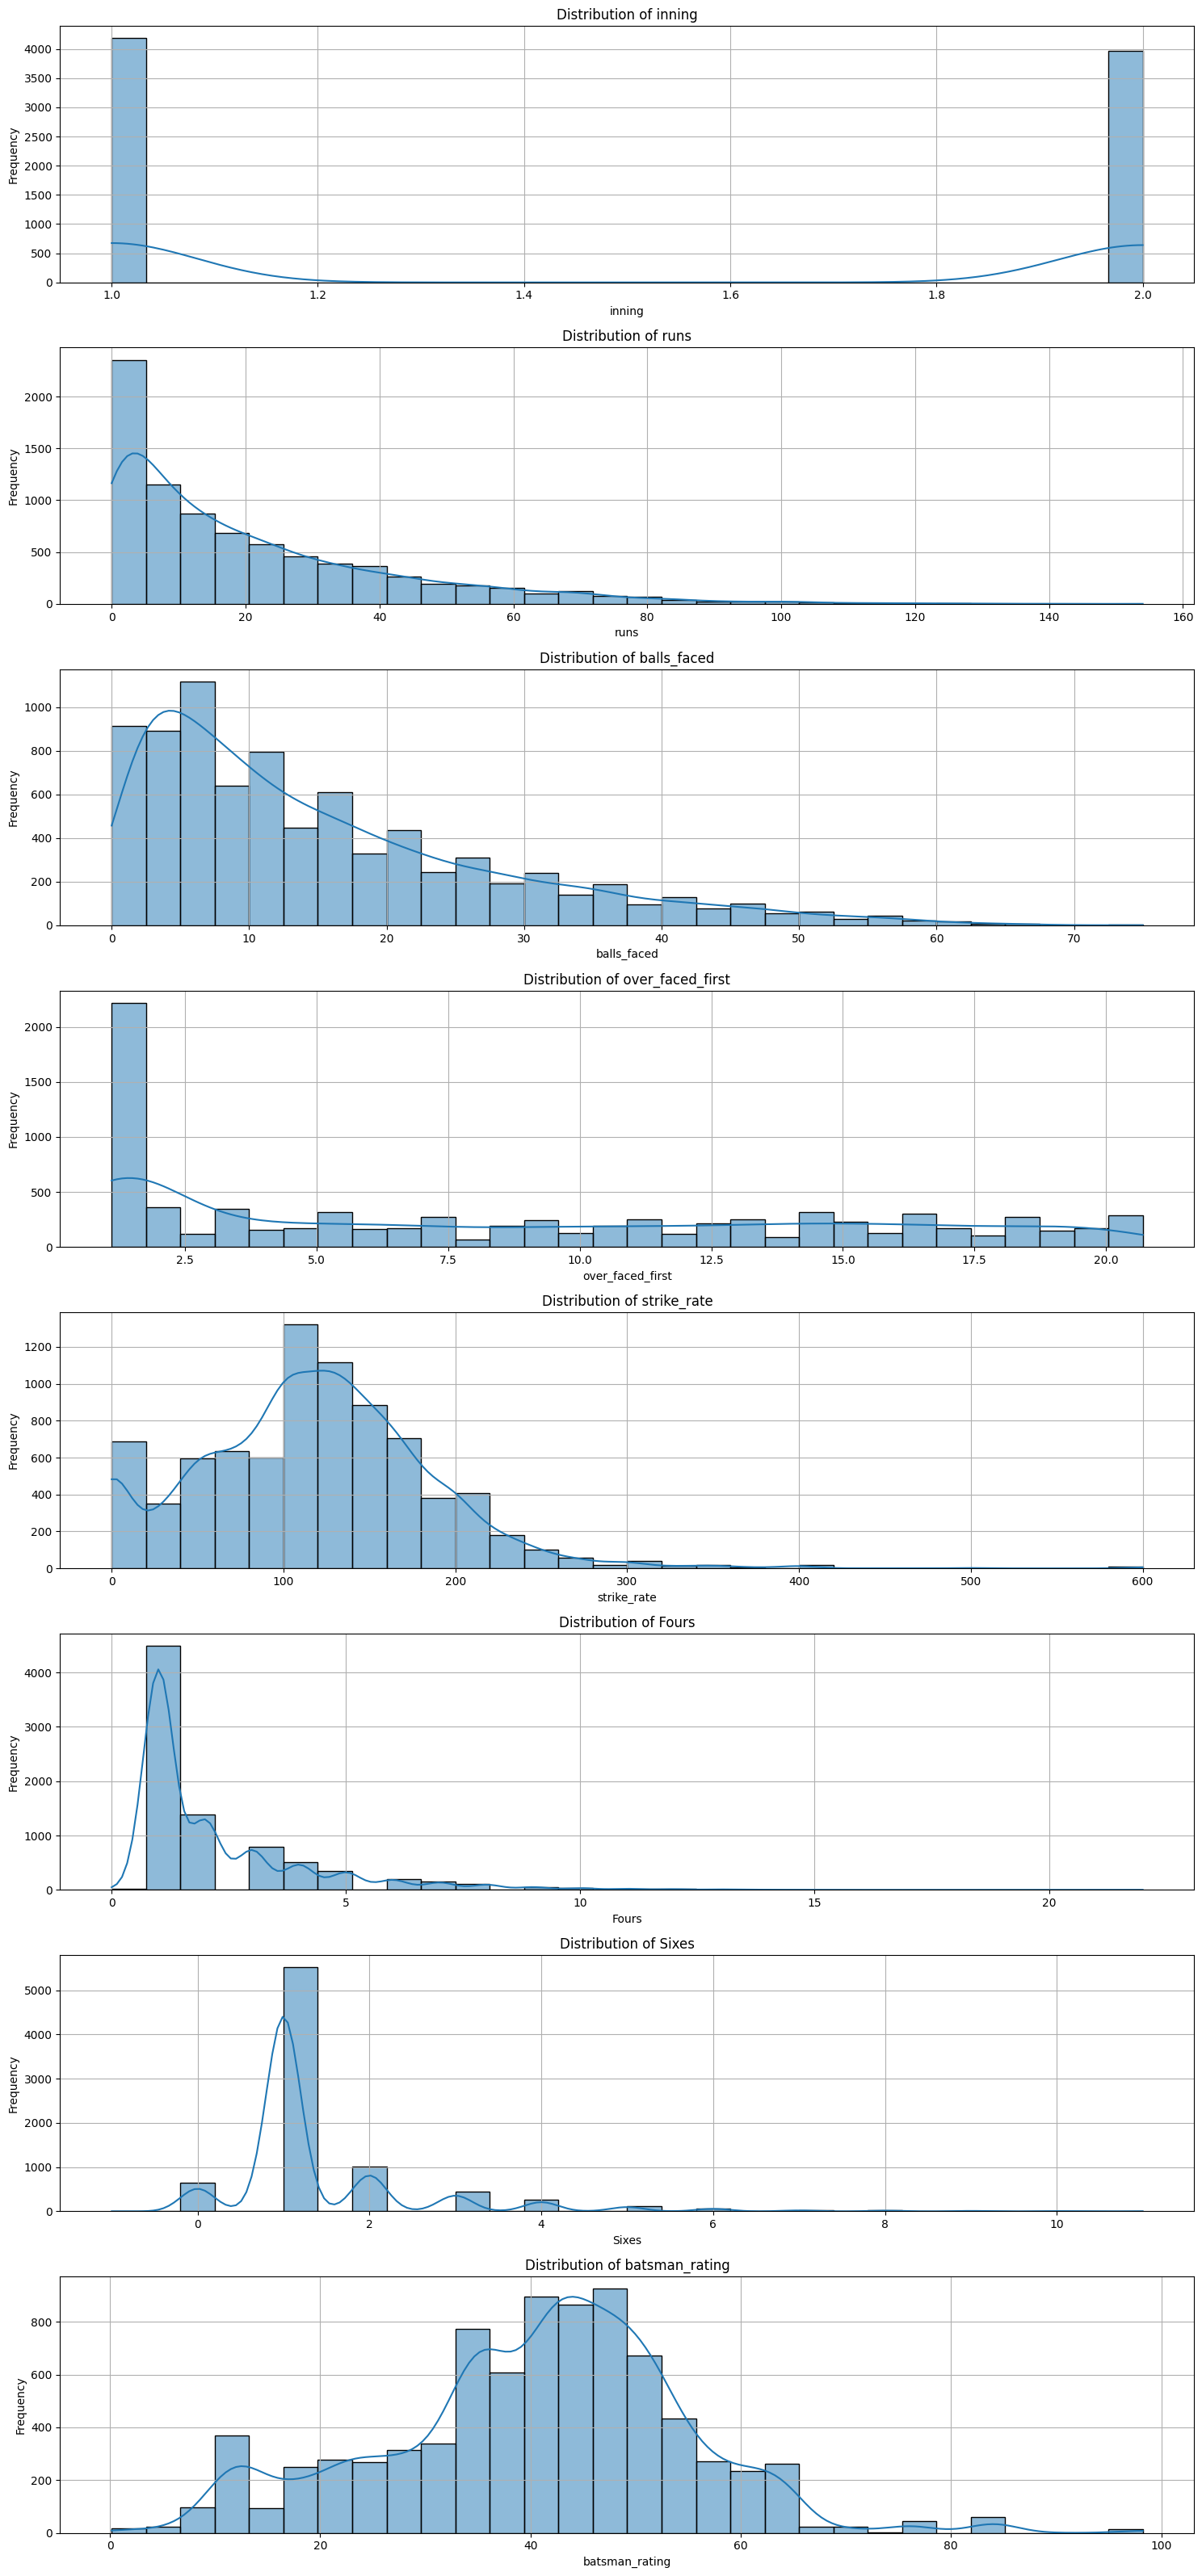

In [51]:
plot_distribution(batsman_df)

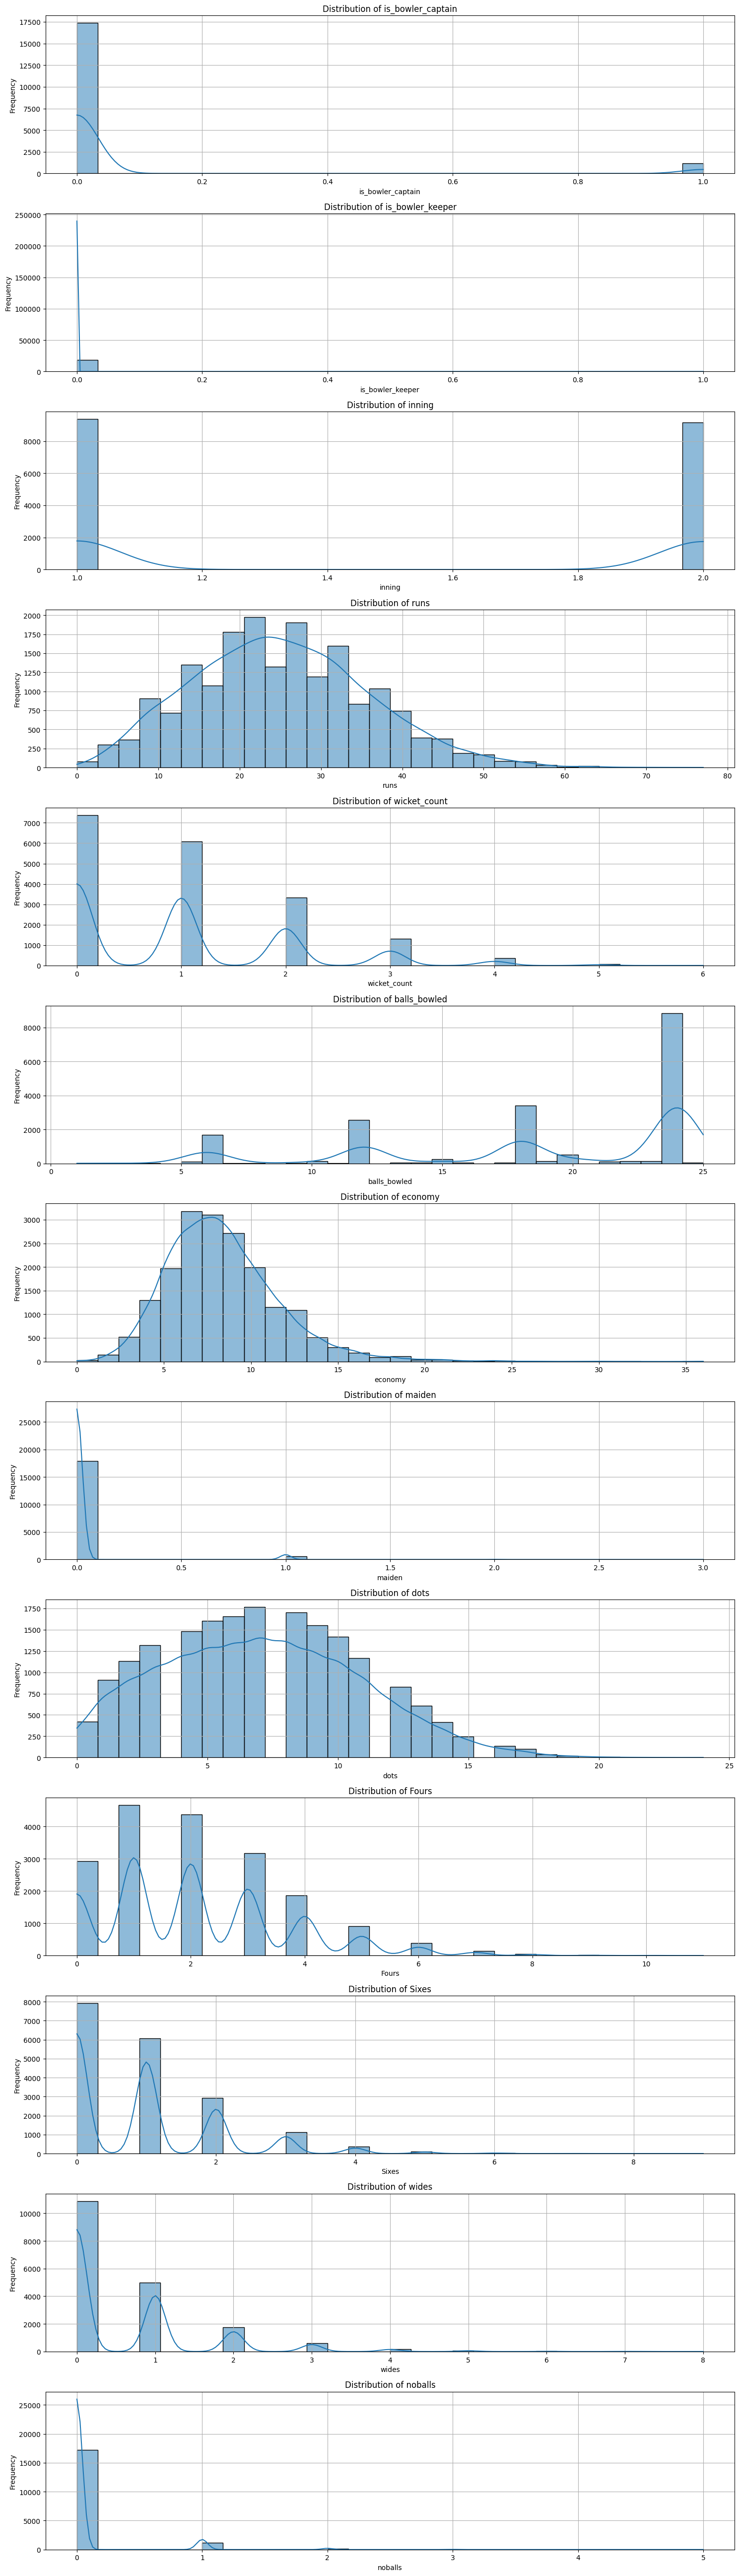

In [52]:
plot_distribution(bowler_df)

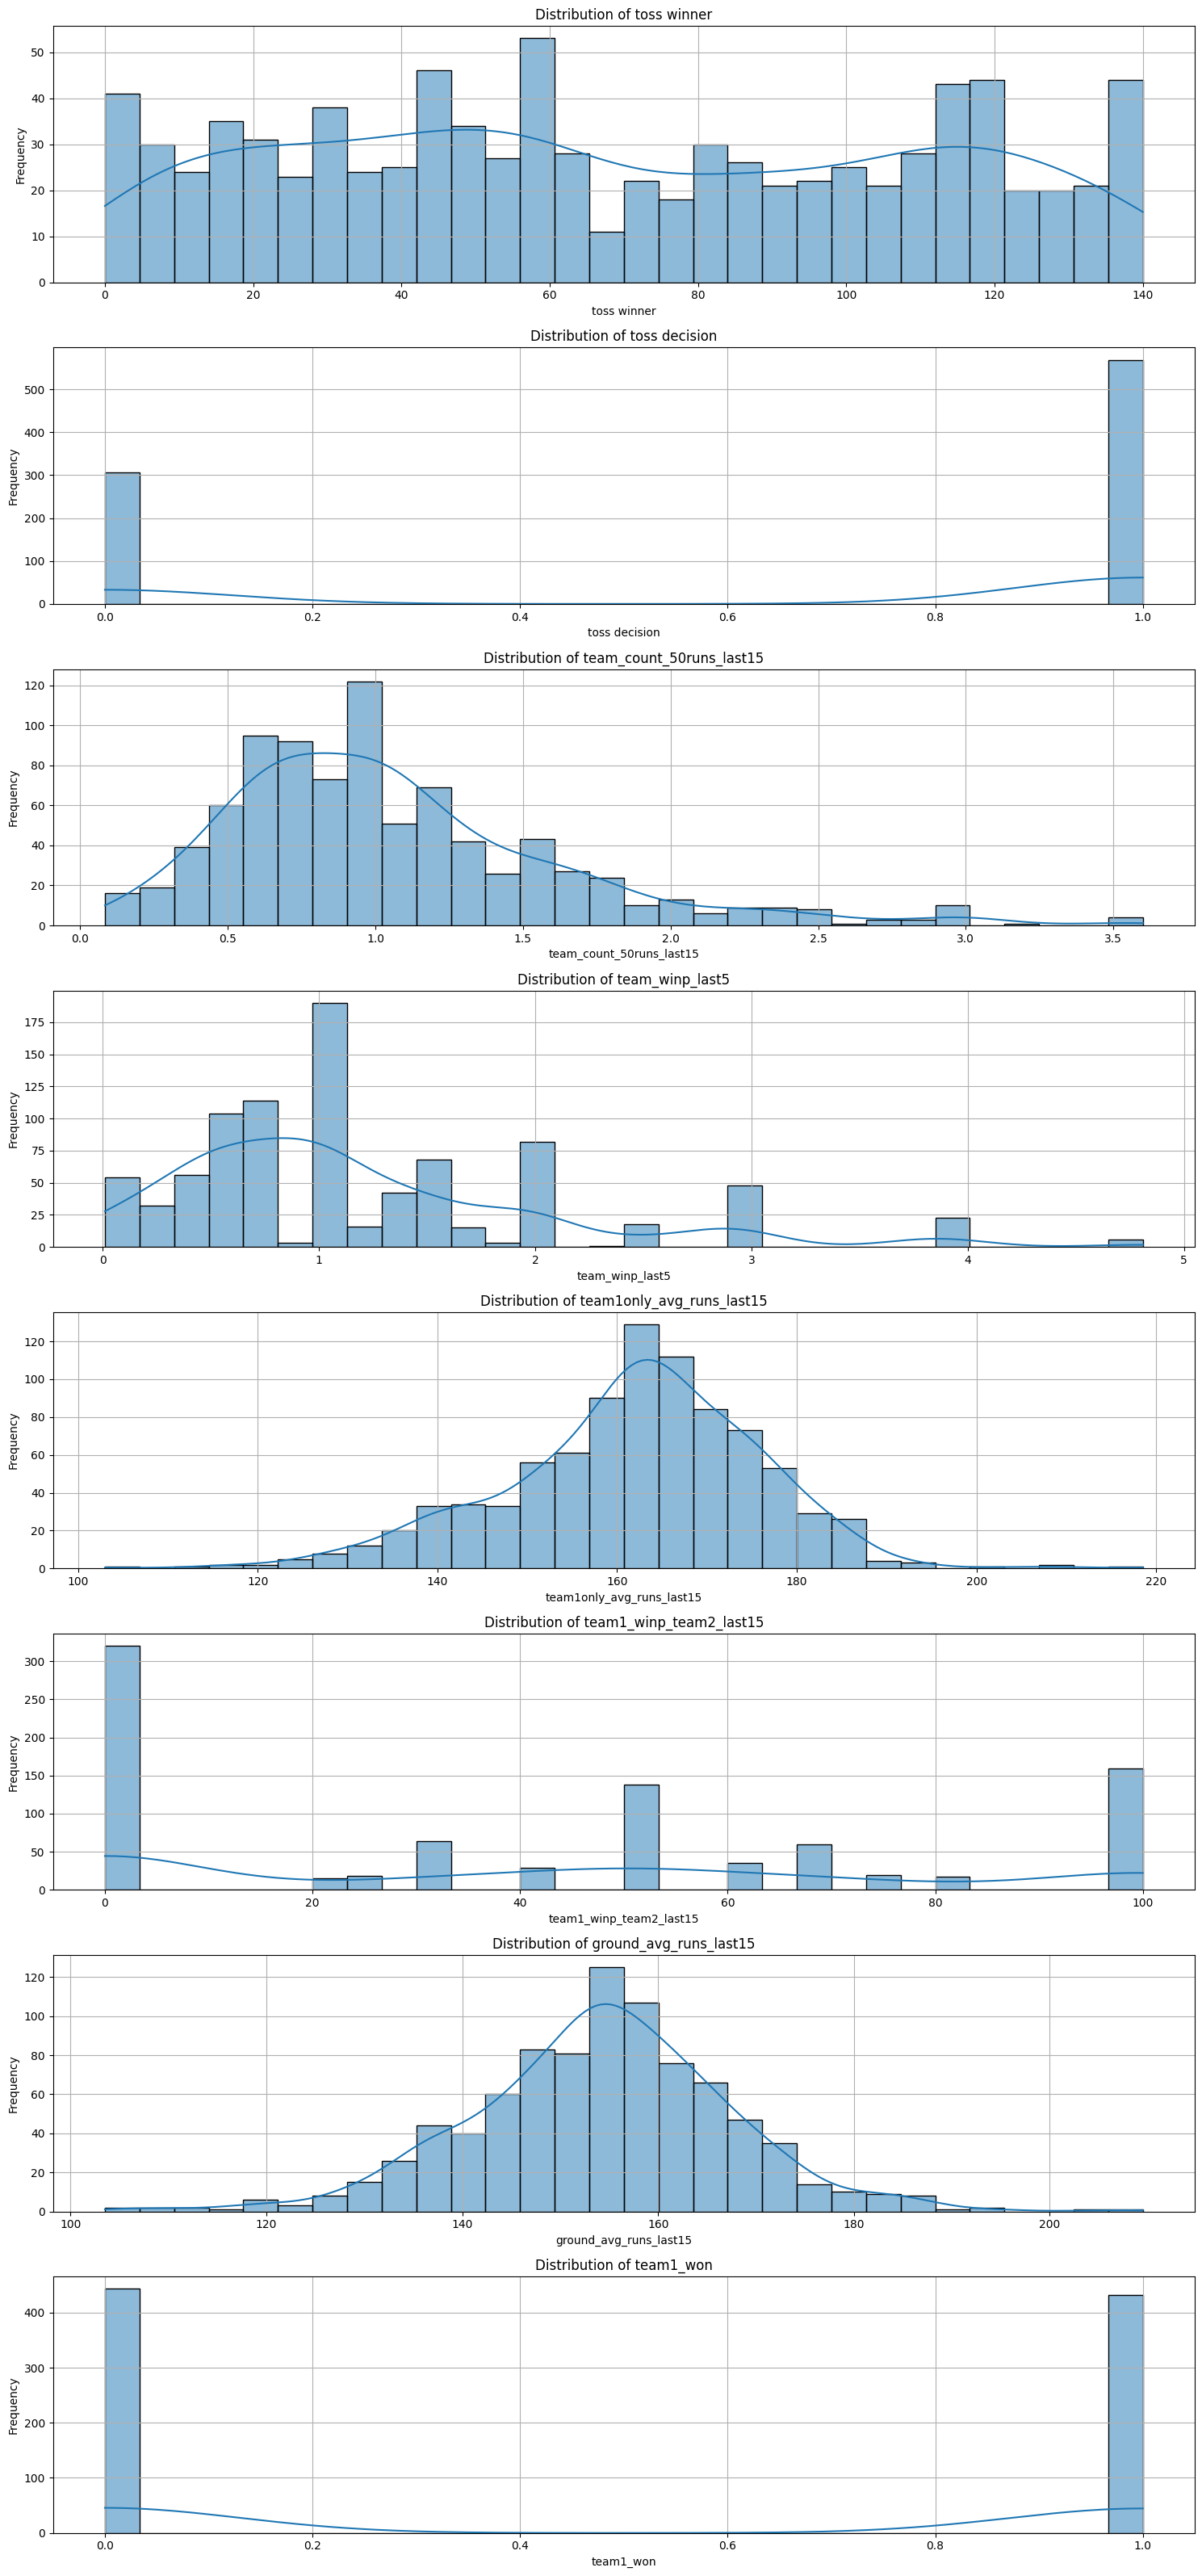

In [53]:
plot_distribution(train_df)

### **Bowler Data Preprocessing**

In [54]:
bowler_df.head()

,match_id,bowler,bowler_id,bowler_details,is_bowler_captain,is_bowler_keeper,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt
0,8638034,BV Ss,6718396.0,NZ:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,21,0,12,10.50,0,3.0,1,1,3,1,2021-01-01
1,8638034,HK Bt,1585464.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,34,1,24,8.50,0,7.0,3,1,2,0,2021-01-01
2,8638034,JS Nm,2486896.0,NZ:Left-hand bat:Right-arm medium-fast:,0.0,0.0,1,23,2,24,5.75,0,12.0,1,1,0,0,2021-01-01
3,8638034,LV vn Bk,3083667.0,NED:Right-hand bat:Right-arm medium-fast:,0.0,0.0,1,31,1,24,7.75,0,9.0,4,0,2,0,2021-01-01
4,8638034,PF Yd,4950294.0,NZ:Right-hand bat:Legbreak googly:,0.0,0.0,1,21,1,24,5.25,0,8.0,0,0,1,0,2021-01-01


In [55]:
bowler_df = bowler_df.drop(columns=['is_bowler_captain','is_bowler_keeper','bowler'])


In [56]:
bowler_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18539 entries, 0 to 18538
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   match_id        18539 non-null  object 
 1   bowler_id       18539 non-null  object 
 2   bowler_details  18539 non-null  object 
 3   inning          18539 non-null  int64  
 4   runs            18539 non-null  int64  
 5   wicket_count    18539 non-null  int64  
 6   balls_bowled    18539 non-null  int64  
 7   economy         18539 non-null  float64
 8   maiden          18539 non-null  int64  
 9   dots            18539 non-null  float64
 10  Fours           18539 non-null  int64  
 11  Sixes           18539 non-null  int64  
 12  wides           18539 non-null  int64  
 13  noballs         18539 non-null  int64  
 14  match_dt        18539 non-null  object 
dtypes: float64(2), int64(9), object(4)
memory usage: 2.1+ MB


In [57]:
new_column_names__ = ['country_bowl', 'batting_style_bowl', 'bowling_style_bowl','space']
bowler_df= split_column_values(bowler_df, 'bowler_details', new_column_names__)

In [58]:
bowler_df = bowler_df.drop(columns=['bowler_details','space'])
bowler_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18539 entries, 0 to 18538
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            18539 non-null  object 
 1   bowler_id           18539 non-null  object 
 2   inning              18539 non-null  int64  
 3   runs                18539 non-null  int64  
 4   wicket_count        18539 non-null  int64  
 5   balls_bowled        18539 non-null  int64  
 6   economy             18539 non-null  float64
 7   maiden              18539 non-null  int64  
 8   dots                18539 non-null  float64
 9   Fours               18539 non-null  int64  
 10  Sixes               18539 non-null  int64  
 11  wides               18539 non-null  int64  
 12  noballs             18539 non-null  int64  
 13  match_dt            18539 non-null  object 
 14  country_bowl        18539 non-null  object 
 15  batting_style_bowl  18539 non-null  object 
 16  bowl

In [59]:
bowler_df.head()

,match_id,bowler_id,inning,runs,wicket_count,balls_bowled,economy,maiden,dots,Fours,Sixes,wides,noballs,match_dt,country_bowl,batting_style_bowl,bowling_style_bowl
0,8638034,6718396.0,1,21,0,12,10.50,0,3.0,1,1,3,1,2021-01-01,NZ,Right-hand bat,Right-arm medium-fast
1,8638034,1585464.0,1,34,1,24,8.50,0,7.0,3,1,2,0,2021-01-01,NZ,Left-hand bat,Right-arm medium-fast
2,8638034,2486896.0,1,23,2,24,5.75,0,12.0,1,1,0,0,2021-01-01,NZ,Left-hand bat,Right-arm medium-fast
3,8638034,3083667.0,1,31,1,24,7.75,0,9.0,4,0,2,0,2021-01-01,NED,Right-hand bat,Right-arm medium-fast
4,8638034,4950294.0,1,21,1,24,5.25,0,8.0,0,0,1,0,2021-01-01,NZ,Right-hand bat,Legbreak googly


### **Calculated Bowler Rating**

In [60]:
import pandas as pd
import numpy as np

def calculate_bowler_rating(bowler_df):
    # Convert match_dt to datetime
    bowler_df['match_dt'] = pd.to_datetime(bowler_df['match_dt'])
    
    # Get the current date for calculating recency
    current_date = bowler_df['match_dt'].max()
    
    # Filter last 7 matches for each bowler
    recent_matches = bowler_df[bowler_df['match_dt'] >= current_date - pd.DateOffset(weeks=15)]
    
    # Calculate recent performance metrics
    recent_performance = recent_matches.groupby('bowler_id').agg({
        'runs': 'sum',
        'wicket_count': 'sum',
        'balls_bowled': 'sum',
        'economy': 'mean',
        'maiden': 'sum',
        'dots': 'sum'
    }).reset_index()
    
    # Calculate overall performance metrics
    overall_performance = bowler_df.groupby('bowler_id').agg({
        'runs': 'sum',
        'wicket_count': 'sum',
        'balls_bowled': 'sum',
        'economy': 'mean',
        'maiden': 'sum',
        'dots': 'sum'
    }).reset_index()
    
    
    # Merge recent and overall performance
    performance = pd.merge(overall_performance, recent_performance, on='bowler_id', suffixes=('_overall', '_recent'))
    
    # Calculate ratings
    performance['recent_wickets'] = performance['wicket_count_recent'] / (performance['balls_bowled_recent'] + 1)
    performance['recent_economy'] = 1 / (performance['economy_recent'] + 1)
    performance['recent_maiden'] = performance['maiden_recent'] / (performance['balls_bowled_recent'] + 1)
    performance['recent_dots'] = performance['dots_recent'] / (performance['balls_bowled_recent'] + 1)
    
    performance['overall_wickets'] = performance['wicket_count_overall'] / (performance['balls_bowled_overall'] + 1)
    performance['overall_economy'] = 1 / (performance['economy_overall'] + 1)
    performance['overall_maiden'] = performance['maiden_overall'] / (performance['balls_bowled_overall'] + 1)
    performance['overall_dots'] = performance['dots_overall'] / (performance['balls_bowled_overall'] + 1)
    
    # Calculate final rating based on weighted metrics
    performance['rating'] = (0.45 * performance['recent_wickets'] + 
                             0.35 * performance['recent_economy'] + 
                             0.30 * performance['recent_maiden'] + 
                             0.25 * performance['recent_dots'] + 
                             0.42 * performance['overall_wickets'] +
                             0.32 * performance['overall_economy'] +
                             0.26 * performance['overall_maiden'] +
                             0.22 * performance['overall_dots'])
    
    return performance[['bowler_id', 'rating']]


In [61]:
# Example usage
# bowler_df = pd.read_csv('bowler_data.csv')  # replace with actual data loading
bowler_ratings = calculate_bowler_rating(bowler_df)
bowler_ratings['bowler_rating']= bowler_ratings['rating']*100
(bowler_ratings).sort_values(by="rating", ascending=False)

,bowler_id,rating,bowler_rating
426,9822392.0,0.684885,68.488541
324,8228009.0,0.562462,56.246154
303,8088695.0,0.554667,55.466657
74,3011735.0,0.518354,51.835421
390,9048360.0,0.497684,49.768421
...,...,...,...
423,9822196.0,0.109018,10.901786
424,9822231.0,0.105808,10.580769
416,9785929.0,0.104365,10.436508
27,2154732.0,0.055833,5.583333


In [62]:
bowler_df= bowler_df.merge(bowler_ratings, on='bowler_id')
bowler_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7868 entries, 0 to 7867
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   match_id            7868 non-null   object        
 1   bowler_id           7868 non-null   object        
 2   inning              7868 non-null   int64         
 3   runs                7868 non-null   int64         
 4   wicket_count        7868 non-null   int64         
 5   balls_bowled        7868 non-null   int64         
 6   economy             7868 non-null   float64       
 7   maiden              7868 non-null   int64         
 8   dots                7868 non-null   float64       
 9   Fours               7868 non-null   int64         
 10  Sixes               7868 non-null   int64         
 11  wides               7868 non-null   int64         
 12  noballs             7868 non-null   int64         
 13  match_dt            7868 non-null   datetime64[n

### **Matchlevel Data Preprocessing**

In [63]:
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8151 entries, 0 to 8150
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   match_id            8151 non-null   object        
 1   batsman_id          8151 non-null   object        
 2   inning              8151 non-null   int64         
 3   runs                8151 non-null   int64         
 4   balls_faced         8151 non-null   int64         
 5   over_faced_first    8151 non-null   float64       
 6   bowler_id           8151 non-null   object        
 7   strike_rate         8151 non-null   float64       
 8   Fours               8151 non-null   float64       
 9   Sixes               8151 non-null   float64       
 10  match_dt            8151 non-null   datetime64[ns]
 11  country_bat         8151 non-null   object        
 12  batting_style_bat   8151 non-null   object        
 13  bowling_style_bat   8151 non-null   object      

In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 0 to 946
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   match_id                   875 non-null    object        
 1   team1_id                   875 non-null    object        
 2   team2_id                   875 non-null    object        
 3   winner_id                  875 non-null    object        
 4   toss winner                875 non-null    int32         
 5   toss decision              875 non-null    int32         
 6   match_dt                   875 non-null    datetime64[ns]
 7   ground_id                  875 non-null    object        
 8   team_count_50runs_last15   875 non-null    float64       
 9   team_winp_last5            875 non-null    float64       
 10  team1only_avg_runs_last15  875 non-null    float64       
 11  team1_winp_team2_last15    875 non-null    float64       
 12  ground_a

In [65]:
matchlevel_df.head()

,match_id,team1,team2,winner,by,win amount,toss winner,toss decision,venue,city,...,inning2_runs,inning2_wickets,inning2_balls,team1_id,team1_roster_ids,team2_id,team2_roster_ids,series_type,winner_id,player_of_the_match_id
0,8638034,Nn Ds,Wn,Wn,wickets,9.0,Wn,field,By Ol,Mount Maunganui,...,152.0,1.0,97.0,17982,7907451.0:4381761.0:31464.0:258649.0:4949790.0...,18570,2653993.0:6718326.0:6718382.0:2486896.0:228878...,other_domestic,18570,nan
1,8588005,Me Rs,Sy Tr,Sy Tr,runs,7.0,Sy Tr,field,Ca Ol,Carrara,...,117.0,2.0,74.0,33942,37351.0:46794.0:5406540.0:2231928.0:181404.0:1...,33963,1506098.0:1749075.0:36665.0:2083409.0:7534652....,other_domestic,33963,1749075.0
2,8587837,Sy Ss,Be Ht,Be Ht,wickets,4.0,Sy Ss,bat,Be Ct Gd,Brisbane,...,171.0,6.0,119.0,33956,7869987.0:7620283.0:2076192.0:4002340.0:306369...,33921,7620269.0:2286437.0:87191.0:5786766.0:3114803....,other_domestic,33921,3890984.0
3,8638041,Nn Ds,Oo,Oo,wickets,2.0,Oo,field,By Ol,Mount Maunganui,...,156.0,8.0,126.0,17982,7907451.0:4381761.0:31464.0:4949790.0:258649.0...,18360,2319638.0:256080.0:7918280.0:3913447.0:2690498...,other_domestic,18360,nan
4,8587921,Ht Hs,Me Ss,Ht Hs,runs,21.0,Me Ss,field,Be Ol,Hobart,...,143.0,9.0,123.0,33928,4223883.0:2161599.0:1655436.0:5788418.0:319948...,33949,363047.0:2275097.0:3901078.0:2275195.0:4230127...,other_domestic,33928,3125849.0


In [66]:
# Create a new column 'team1_won_toss' based on the condition
matchlevel_df['team1_won_toss'] = np.where(matchlevel_df['toss winner'] == matchlevel_df['team1'], 1, 0)

matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_id                1689 non-null   object 
 1   team1                   1689 non-null   object 
 2   team2                   1689 non-null   object 
 3   winner                  1689 non-null   object 
 4   by                      1689 non-null   object 
 5   win amount              1689 non-null   float64
 6   toss winner             1689 non-null   object 
 7   toss decision           1689 non-null   object 
 8   venue                   1689 non-null   object 
 9   city                    1511 non-null   object 
 10  match_dt                1689 non-null   object 
 11  lighting                1689 non-null   object 
 12  series_name             1689 non-null   object 
 13  season                  1689 non-null   object 
 14  ground_id               1689 non-null   

In [67]:
matchlevel_df=matchlevel_df.drop(columns=["team1","team2","winner","toss winner","venue","city","lighting","series_name","season","series_type","umpire1","umpire2"])
matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_id                1689 non-null   object 
 1   by                      1689 non-null   object 
 2   win amount              1689 non-null   float64
 3   toss decision           1689 non-null   object 
 4   match_dt                1689 non-null   object 
 5   ground_id               1689 non-null   object 
 6   inning1_runs            1689 non-null   int64  
 7   inning1_wickets         1689 non-null   int64  
 8   inning1_balls           1689 non-null   int64  
 9   inning2_runs            1689 non-null   float64
 10  inning2_wickets         1689 non-null   float64
 11  inning2_balls           1689 non-null   float64
 12  team1_id                1689 non-null   object 
 13  team1_roster_ids        1689 non-null   object 
 14  team2_id                1689 non-null   

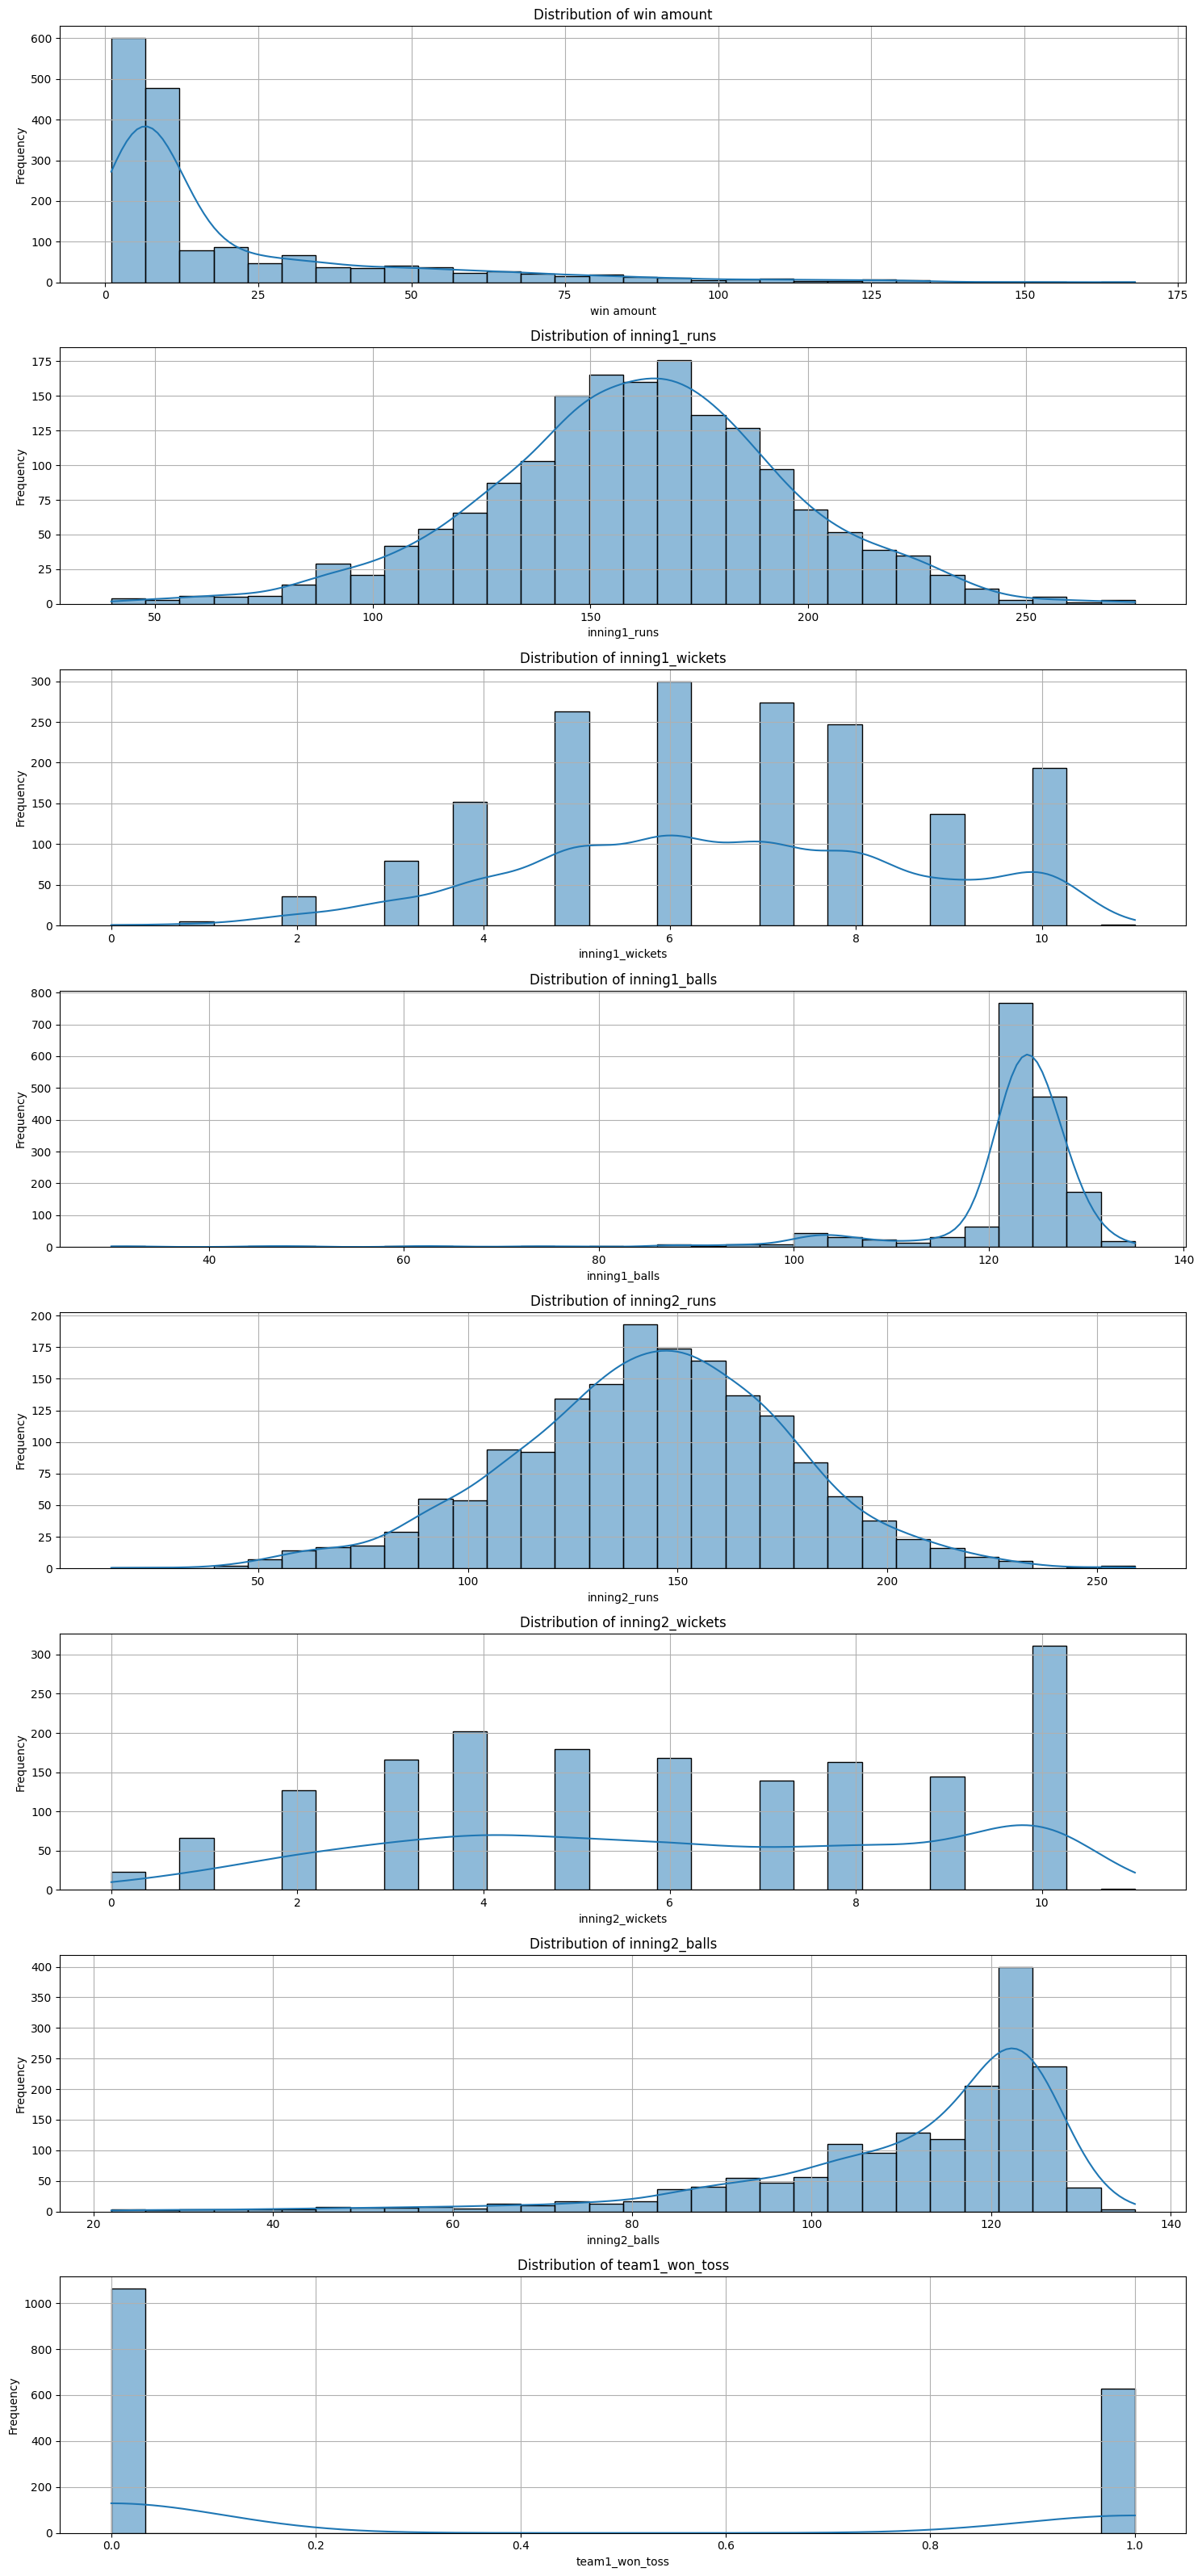

In [68]:
plot_distribution(matchlevel_df)

In [69]:
matchlevel_df=split_roster_ids(matchlevel_df)
matchlevel_df= matchlevel_df.drop(columns=["team1_roster_ids","team2_roster_ids"])
matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_id                1689 non-null   object 
 1   by                      1689 non-null   object 
 2   win amount              1689 non-null   float64
 3   toss decision           1689 non-null   object 
 4   match_dt                1689 non-null   object 
 5   ground_id               1689 non-null   object 
 6   inning1_runs            1689 non-null   int64  
 7   inning1_wickets         1689 non-null   int64  
 8   inning1_balls           1689 non-null   int64  
 9   inning2_runs            1689 non-null   float64
 10  inning2_wickets         1689 non-null   float64
 11  inning2_balls           1689 non-null   float64
 12  team1_id                1689 non-null   object 
 13  team2_id                1689 non-null   object 
 14  winner_id               1689 non-null   

In [70]:
matchlevel_df= convert_to_object(matchlevel_df,columns_to_convert)
matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_id                1689 non-null   object 
 1   by                      1689 non-null   object 
 2   win amount              1689 non-null   float64
 3   toss decision           1689 non-null   object 
 4   match_dt                1689 non-null   object 
 5   ground_id               1689 non-null   object 
 6   inning1_runs            1689 non-null   int64  
 7   inning1_wickets         1689 non-null   int64  
 8   inning1_balls           1689 non-null   int64  
 9   inning2_runs            1689 non-null   float64
 10  inning2_wickets         1689 non-null   float64
 11  inning2_balls           1689 non-null   float64
 12  team1_id                1689 non-null   object 
 13  team2_id                1689 non-null   object 
 14  winner_id               1689 non-null   

In [71]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encode_categorical_columns(df):
   
    # Label Encoding for 'toss decision'
    label_encoder = LabelEncoder()
    df['toss_decision_encoded'] = label_encoder.fit_transform(df['toss decision'])
    
    # One-Hot Encoding for 'by' column
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
    by_encoded = one_hot_encoder.fit_transform(df[['by']])
    
    # Create a DataFrame with the one-hot encoded columns
    by_encoded_df = pd.DataFrame(by_encoded, columns=one_hot_encoder.get_feature_names_out(['by']))
    
    # Concatenate the one-hot encoded columns to the original DataFrame
    df = pd.concat([df, by_encoded_df], axis=1)
    
    # Drop the original columns if needed
    df.drop(['by', 'toss decision'], axis=1, inplace=True)
    
    return df

# Example usage
matchlevel_df = encode_categorical_columns(matchlevel_df)
matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_id                1689 non-null   object 
 1   win amount              1689 non-null   float64
 2   match_dt                1689 non-null   object 
 3   ground_id               1689 non-null   object 
 4   inning1_runs            1689 non-null   int64  
 5   inning1_wickets         1689 non-null   int64  
 6   inning1_balls           1689 non-null   int64  
 7   inning2_runs            1689 non-null   float64
 8   inning2_wickets         1689 non-null   float64
 9   inning2_balls           1689 non-null   float64
 10  team1_id                1689 non-null   object 
 11  team2_id                1689 non-null   object 
 12  winner_id               1689 non-null   object 
 13  player_of_the_match_id  1689 non-null   object 
 14  team1_won_toss          1689 non-null   

In [72]:
# Create a new column 'team1_won' based on the condition
matchlevel_df['team1_won'] = np.where(matchlevel_df['winner_id'] == matchlevel_df['team1_id'], 1, 0)

In [73]:
column_rearrange = ["by_wickets","toss_decision_encoded","team1_won_toss"]
# Move 'column_name' to position 2 (index starts at 0)
def column_rearrange_func(df, columns,start):
    for col in columns:
        column = df.pop(col)
        df.insert(start, col, column)
    return df
column_rearrange_func(matchlevel_df,column_rearrange,1)
matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   match_id                1689 non-null   object 
 1   team1_won_toss          1689 non-null   int32  
 2   toss_decision_encoded   1689 non-null   int32  
 3   by_wickets              1689 non-null   float64
 4   win amount              1689 non-null   float64
 5   match_dt                1689 non-null   object 
 6   ground_id               1689 non-null   object 
 7   inning1_runs            1689 non-null   int64  
 8   inning1_wickets         1689 non-null   int64  
 9   inning1_balls           1689 non-null   int64  
 10  inning2_runs            1689 non-null   float64
 11  inning2_wickets         1689 non-null   float64
 12  inning2_balls           1689 non-null   float64
 13  team1_id                1689 non-null   object 
 14  team2_id                1689 non-null   

In [74]:
matchlevel_df["match_dt"]= pd.to_datetime(matchlevel_df["match_dt"])
matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   match_id                1689 non-null   object        
 1   team1_won_toss          1689 non-null   int32         
 2   toss_decision_encoded   1689 non-null   int32         
 3   by_wickets              1689 non-null   float64       
 4   win amount              1689 non-null   float64       
 5   match_dt                1689 non-null   datetime64[ns]
 6   ground_id               1689 non-null   object        
 7   inning1_runs            1689 non-null   int64         
 8   inning1_wickets         1689 non-null   int64         
 9   inning1_balls           1689 non-null   int64         
 10  inning2_runs            1689 non-null   float64       
 11  inning2_wickets         1689 non-null   float64       
 12  inning2_balls           1689 non-null   float64 

### **Calculated ground Rating**

In [75]:
import pandas as pd

def calculate_ground_rating(matchlevel_df):
    # Aggregate statistics for each ground
    ground_stats = matchlevel_df.groupby('ground_id').agg({
        'inning1_runs': 'mean',
        'inning2_runs': 'mean',
        'inning1_wickets': 'mean',
        'inning2_wickets': 'mean',
        'inning1_balls': 'mean',
        'inning2_balls': 'mean',
    }).reset_index()
    
    # Rename columns for clarity
    ground_stats.rename(columns={
        'inning1_runs': 'average_runs_inning1',
        'inning2_runs': 'average_runs_inning2',
        'inning1_wickets': 'average_wickets_inning1',
        'inning2_wickets': 'average_wickets_inning2',
        'inning1_balls': 'average_balls_inning1',
        'inning2_balls': 'average_balls_inning2',
    }, inplace=True)
    
    # Calculate batting and bowling ratings
    ground_stats['ground_rating_bat'] = (ground_stats['average_runs_inning1'] + ground_stats['average_runs_inning2']) / 2
    ground_stats['ground_rating_bowl'] = -((ground_stats['average_runs_inning1'] + ground_stats['average_runs_inning2']) / 2)
    
    # Additional metrics for innings-wise batting and bowling
    ground_stats['average_wickets_per_inning'] = (ground_stats['average_wickets_inning1'] + ground_stats['average_wickets_inning2']) / 2
    ground_stats['average_balls_per_inning'] = (ground_stats['average_balls_inning1'] + ground_stats['average_balls_inning2']) / 2
    
    # Normalize the ratings (optional, for consistency)
    max_bat_rating = ground_stats['ground_rating_bat'].max()
    min_bowl_rating = ground_stats['ground_rating_bowl'].min()
    
    ground_stats['ground_rating_bat'] = (ground_stats['ground_rating_bat'] - ground_stats['ground_rating_bat'].min()) / (max_bat_rating - ground_stats['ground_rating_bat'].min())
    ground_stats['ground_rating_bowl'] = (ground_stats['ground_rating_bowl'] - min_bowl_rating) / (ground_stats['ground_rating_bowl'].max() - min_bowl_rating)
    
    return ground_stats[['ground_id','ground_rating_bat', 'ground_rating_bowl']]


In [76]:
# Example usage
# matchlevel_df = pd.read_csv('match_level_data.csv')  # replace with actual data loading
ground_ratings = calculate_ground_rating(matchlevel_df)
ground_ratings.sort_values(by='ground_rating_bat',ascending=False)


,ground_id,ground_rating_bat,ground_rating_bowl
129,7020,1.000000,0.000000
124,6579,0.978137,0.021863
93,3135,0.940985,0.059015
111,4794,0.920746,0.079254
84,24828,0.881654,0.118346
...,...,...,...
50,17632,0.362643,0.637357
89,25479,0.349335,0.650665
71,21958,0.316730,0.683270
41,16806,0.272814,0.727186


In [77]:
matchlevel_df = matchlevel_df.merge(ground_ratings, on='ground_id')


C:\Users\RDRL\AppData\Local\Temp\ipykernel_24080\3667769648.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  match_corr = matchlevel_df.corr()


<Axes: >

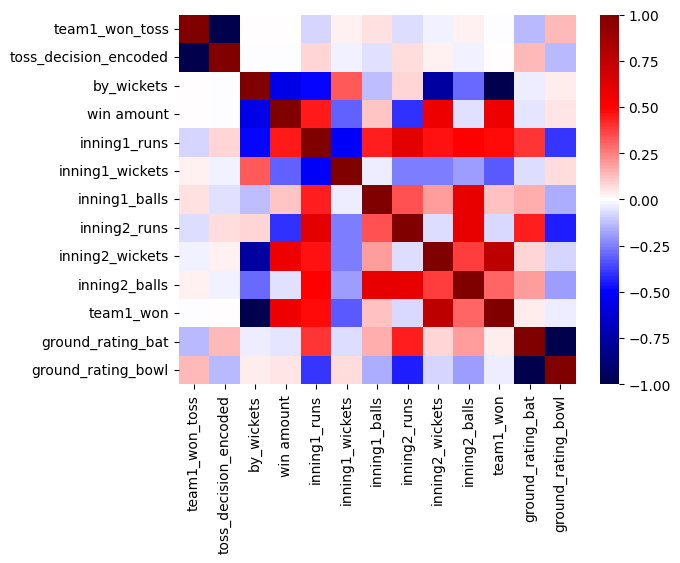

In [78]:
match_corr = matchlevel_df.corr()
sns.heatmap(match_corr,cmap='seismic')

### Checking final Info of df's

In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 0 to 946
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   match_id                   875 non-null    object        
 1   team1_id                   875 non-null    object        
 2   team2_id                   875 non-null    object        
 3   winner_id                  875 non-null    object        
 4   toss winner                875 non-null    int32         
 5   toss decision              875 non-null    int32         
 6   match_dt                   875 non-null    datetime64[ns]
 7   ground_id                  875 non-null    object        
 8   team_count_50runs_last15   875 non-null    float64       
 9   team_winp_last5            875 non-null    float64       
 10  team1only_avg_runs_last15  875 non-null    float64       
 11  team1_winp_team2_last15    875 non-null    float64       
 12  ground_a

In [80]:
bowler_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7868 entries, 0 to 7867
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   match_id            7868 non-null   object        
 1   bowler_id           7868 non-null   object        
 2   inning              7868 non-null   int64         
 3   runs                7868 non-null   int64         
 4   wicket_count        7868 non-null   int64         
 5   balls_bowled        7868 non-null   int64         
 6   economy             7868 non-null   float64       
 7   maiden              7868 non-null   int64         
 8   dots                7868 non-null   float64       
 9   Fours               7868 non-null   int64         
 10  Sixes               7868 non-null   int64         
 11  wides               7868 non-null   int64         
 12  noballs             7868 non-null   int64         
 13  match_dt            7868 non-null   datetime64[n

In [81]:
batsman_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8151 entries, 0 to 8150
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   match_id            8151 non-null   object        
 1   batsman_id          8151 non-null   object        
 2   inning              8151 non-null   int64         
 3   runs                8151 non-null   int64         
 4   balls_faced         8151 non-null   int64         
 5   over_faced_first    8151 non-null   float64       
 6   bowler_id           8151 non-null   object        
 7   strike_rate         8151 non-null   float64       
 8   Fours               8151 non-null   float64       
 9   Sixes               8151 non-null   float64       
 10  match_dt            8151 non-null   datetime64[ns]
 11  country_bat         8151 non-null   object        
 12  batting_style_bat   8151 non-null   object        
 13  bowling_style_bat   8151 non-null   object      

In [82]:
matchlevel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   match_id                1689 non-null   object        
 1   team1_won_toss          1689 non-null   int32         
 2   toss_decision_encoded   1689 non-null   int32         
 3   by_wickets              1689 non-null   float64       
 4   win amount              1689 non-null   float64       
 5   match_dt                1689 non-null   datetime64[ns]
 6   ground_id               1689 non-null   object        
 7   inning1_runs            1689 non-null   int64         
 8   inning1_wickets         1689 non-null   int64         
 9   inning1_balls           1689 non-null   int64         
 10  inning2_runs            1689 non-null   float64       
 11  inning2_wickets         1689 non-null   float64       
 12  inning2_balls           1689 non-null   float64 

In [83]:
import pandas as pd

def calculate_total_unique_players_from_col(matchlevel_df):
    # Columns that contain player IDs
    player_columns = [col for col in matchlevel_df.columns if 'player' in col]
    
    # Extract player IDs from the specified columns
    player_ids = pd.concat([matchlevel_df[col] for col in player_columns], ignore_index=True)
    
    # Drop any NaN values and get unique player IDs
    unique_player_ids_matchlevel = player_ids.dropna().unique()
    
    # Count the total number of unique players
    total_unique_players = len(unique_player_ids_matchlevel)
    
    return total_unique_players, unique_player_ids_matchlevel

# Example usage
# matchlevel_df = pd.read_csv('matchlevel_data.csv')  # replace with actual data loading




In [84]:
import pandas as pd

def calculate_total_unique_players( batsman_df, bowler_df):
    # Extract player IDs from all relevant columns
    batsman_ids = batsman_df['batsman_id'].unique()
    bowler_ids = bowler_df['bowler_id'].unique()
    
    # Combine player IDs into a single list
    all_player_ids = set(batsman_ids).union(set(bowler_ids))
    
    # Count the total number of unique players
    total_unique_players = len(all_player_ids)
    
    return total_unique_players ,all_player_ids

# Example usage
# matchlevel_df = pd.read_csv('matchlevel_data.csv')  # replace with actual data loading
# batsman_df = pd.read_csv('batsman_data.csv')  # replace with actual data loading
# bowler_df = pd.read_csv('bowler_data.csv')  # replace with actual data loading

total_unique_players , all_players_id = calculate_total_unique_players(batsman_df, bowler_df)
print(f"Total unique players ever played: {total_unique_players}")


Total unique players ever played: 581


In [85]:
total_unique_players_match, unique_player_ids_matchlevel = calculate_total_unique_players_from_col(matchlevel_df)
print(f"Total unique players ever played in matchlevel: {total_unique_players_match}")
total_unique_players_bat, unique_player_ids_batsman = calculate_total_unique_players_from_col(train_df)
print(f"Total unique players ever played in train: {total_unique_players_bat}")
total_unique_players , all_players_id = calculate_total_unique_players(batsman_df, bowler_df)
print(f"Total unique players ever played in bat & bowl: {total_unique_players}")

Total unique players ever played in matchlevel: 3371
Total unique players ever played in train: 2115
Total unique players ever played in bat & bowl: 581


In [86]:
unique_elements = set(unique_player_ids_batsman) | set(unique_player_ids_matchlevel) | set(all_players_id)
len(unique_elements)

3731

In [87]:
bowler_df['bowler_id'].nunique()

431

In [88]:
batsman_df['batsman_id'].nunique()

315

### **Merging the ratings**

In [89]:
batsman_df_ =batsman_df.copy()
bowler_df_=bowler_df.copy()
matchlevel_df_=matchlevel_df.copy()
train_df_=train_df.copy()

In [90]:
# Rename columns to avoid conflict during merge
bowler_df_ = bowler_df_.rename(columns={'bowler_rating': 'bowling_rating'})
batsman_df_ = batsman_df_.rename(columns={'batsman_rating': 'batting_rating'})

In [204]:
import pandas as pd
import numpy as np

def create_final_rating_df(train_df, batsman_df, bowler_df):
    # Step 1: Extract unique player IDs from train_df
    team1_players = train_df[[f'team1_player_{i}' for i in range(1, 12)]].values.flatten()
    team2_players = train_df[[f'team2_player_{i}' for i in range(1, 12)]].values.flatten()
    all_players = pd.unique(np.concatenate([team1_players, team2_players]))

    # Step 2: Prepare ratings from batsman_df and bowler_df
    batsman_ratings = batsman_df[['batsman_id', 'batting_rating']].drop_duplicates()
    bowler_ratings = bowler_df[['bowler_id', 'bowling_rating']].drop_duplicates()

    # Rename columns for merging
    batsman_ratings.rename(columns={'batsman_id': 'player_id', 'batting_rating': 'rating'}, inplace=True)
    bowler_ratings.rename(columns={'bowler_id': 'player_id', 'bowling_rating': 'rating'}, inplace=True)

    # Combine ratings into one DataFrame
    combined_ratings = pd.concat([batsman_ratings, bowler_ratings], ignore_index=True)

    # Debugging: Print combined_ratings to verify the data
    print("Combined Ratings DataFrame:")
    print(combined_ratings.head())

    # Step 3: Create final rating DataFrame with unique players
    final_rating_df = pd.DataFrame({'player_id': all_players})

    # Merge combined ratings into final rating DataFrame
    final_rating_df = final_rating_df.merge(combined_ratings, on='player_id', how='left')

    # Debugging: Print final_rating_df to check the merged results
    print("Final Rating DataFrame after Merge:")
    print(final_rating_df.head())

    # Step 4: Handle missing ratings
    # Calculate default_rating only if there are valid ratings
    if final_rating_df['rating'].notna().any():
        default_rating = final_rating_df['rating'].dropna().mean()
    else:
        default_rating = 0  # Or any other appropriate default value

    # Fill missing ratings with default_rating
    final_rating_df['final_rating'] = final_rating_df['rating'].fillna(default_rating)

    # Drop the 'rating' column as it's no longer needed
    final_rating_df.drop(columns='rating', inplace=True)

    # Debugging: Print final_rating_df to verify the result
    print("Final Rating DataFrame with Final Ratings:")
    print(final_rating_df.head())

    return final_rating_df

# Example usage
final_rating_df = create_final_rating_df(train_df_, batsman_df_, bowler_df_)


Combined Ratings DataFrame:
   player_id     rating
0  7907451.0  49.930197
1  4381761.0  34.851869
2  4949790.0  56.514691
3  3834305.0  41.468603
4  3776849.0  54.227556
Final Rating DataFrame after Merge:
  player_id  rating
0   9373356     NaN
1   7857520     NaN
2   4232164     NaN
3   4566540     NaN
4   3299407     NaN
Final Rating DataFrame with Final Ratings:
  player_id  final_rating
0   9373356           0.0
1   7857520           0.0
2   4232164           0.0
3   4566540           0.0
4   3299407           0.0


In [203]:
final_rating_df.sample(10)

,player_id,final_rating
1100,4817000,0.0
1150,3083891,0.0
693,392419,0.0
2020,1883790,0.0
616,9047499,0.0
879,8522310,0.0
2050,9104101,0.0
1910,7785497,0.0
373,3546297,0.0
729,1539236,0.0


In [153]:
batsman_ratings['player_id']=batsman_ratings['batsman_id']
batsman_ratings

,batsman_id,batsman_rating,player_id
0,1482998.0,34.606844,1482998.0
1,1506098.0,48.402947,1506098.0
2,1585457.0,52.514283,1585457.0
3,1594319.0,47.754514,1594319.0
4,1611364.0,45.499901,1611364.0
...,...,...,...
310,9403421.0,32.287286,9403421.0
311,9663968.0,22.848125,9663968.0
312,9806957.0,16.226500,9806957.0
313,9874052.0,74.376190,9874052.0


## **Feature Engineering from other data sets**

In [ ]:
# Rating Calculation Functions
def calculate_batsman_rating(row):
    runs = row['runs']
    strike_rate = row['strike_rate']
    fours = row['Fours']
    sixes = row['Sixes']
    return runs + strike_rate * 0.2 + fours * 0.3 + sixes * 0.5

def calculate_bowler_rating(row):
    wickets = row['wicket_count']
    economy = row['economy']
    dots = row['dots']
    return wickets * 10 - economy * 2 + dots * 0.5


def calculate_allrounder_rating(batsman_row, bowler_row):
    batsman_rating = calculate_batsman_rating(batsman_row)
    bowler_rating = calculate_bowler_rating(bowler_row)
    return batsman_rating + bowler_rating


In [ ]:
# Calculate Ratings for Batsmen
batsman_df['batsman_rating'] = batsman_df.apply(calculate_batsman_rating, axis=1)
batsman_ratings = batsman_df.groupby('batsman_id')['batsman_rating'].mean().to_dict()

# Calculate Ratings for Bowlers
bowler_df['bowler_rating'] = bowler_df.apply(calculate_bowler_rating, axis=1)
bowler_ratings = bowler_df.groupby('bowler_id')['bowler_rating'].mean().to_dict()

In [ ]:
batsman_ratings

In [ ]:
# Replace Roster IDs with Ratings
def replace_roster_ids_with_ratings(df):
    max_players = 11  # Assuming maximum 11 players per team
    def get_rating(player_id):
        batsman_rating = batsman_ratings.get(player_id, np.nan)
        bowler_rating = bowler_ratings.get(player_id, np.nan)
        
        if not np.isnan(batsman_rating) and not np.isnan(bowler_rating):
            return batsman_rating + bowler_rating  # Allrounder
        elif not np.isnan(batsman_rating):
            return batsman_rating
        elif not np.isnan(bowler_rating):
            return bowler_rating
        else:
            return np.nan

    for i in range(max_players):
        df[f'team1_player_{i+1}_rating'] = df['team1_roster_ids'].apply(lambda x: get_rating(float(x.split(':')[i])) if len(x.split(':')) > i else np.nan)
        df[f'team2_player_{i+1}_rating'] = df['team2_roster_ids'].apply(lambda x: get_rating(float(x.split(':')[i])) if len(x.split(':')) > i else np.nan)
    
    return df

In [ ]:


train_df = replace_roster_ids_with_ratings(train_df)
test_df = replace_roster_ids_with_ratings(test_df)

# Drop the original roster ID columns as they have been replaced
train_df = train_df.drop(['team1_roster_ids', 'team2_roster_ids'], axis=1)
test_df = test_df.drop(['team1_roster_ids', 'team2_roster_ids'], axis=1)

# Prepare training and test sets
X = train_df.drop(['match_id', 'winner', 'winner_id'], axis=1)
y = train_df['winner_id']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.drop(['match_id'], axis=1)

In [ ]:




train_df = replace_roster_ids_with_ratings(train_df)
test_df = replace_roster_ids_with_ratings(test_df)

# Drop the original roster ID columns as they have been replaced
train_df = train_df.drop(['team1_roster_ids', 'team2_roster_ids'], axis=1)
test_df = test_df.drop(['team1_roster_ids', 'team2_roster_ids'], axis=1)


In [ ]:
# # Feature Engineering
# def feature_engineering(df, bowler_df, batsman_df):
#     # Aggregate bowler performance
#     bowler_stats = bowler_df.groupby('bowler_id').agg({
#         'runs': 'mean',
#         'wicket_count': 'mean',
#         'balls_bowled': 'mean',
#         'economy': 'mean',
#         'maiden': 'mean',
#         'dots': 'mean',
#         'Fours': 'mean',
#         'Sixes': 'mean',
#         'wides': 'mean',
#         'noballs': 'mean'
#     }).reset_index()

#     # Aggregate batsman performance
#     batsman_stats = batsman_df.groupby('batsman_id').agg({
#         'runs': 'mean',
#         'balls_faced': 'mean',
#         'strike_rate': 'mean',
#         'Fours': 'mean',
#         'Sixes': 'mean'
#     }).reset_index()

#     # Merge player performance with main dataframe
#     for i in range(11):
#         df = df.merge(bowler_stats, left_on=f'team1_player_{i+1}', right_on='bowler_id', how='left', suffixes=('', f'_bowler_{i+1}'))
#         df = df.merge(bowler_stats, left_on=f'team2_player_{i+1}', right_on='bowler_id', how='left', suffixes=('', f'_bowler_{i+1}'))
#         df = df.merge(batsman_stats, left_on=f'team1_player_{i+1}', right_on='batsman_id', how='left', suffixes=('', f'_batsman_{i+1}'))
#         df = df.merge(batsman_stats, left_on=f'team2_player_{i+1}', right_on='batsman_id', how='left', suffixes=('', f'_batsman_{i+1}'))
    
#     # Drop redundant columns
#     df.drop(columns=['bowler_id', 'batsman_id'], inplace=True, errors='ignore')

#     return df

In [ ]:

train_df = feature_engineering(train_df, bowler_df, batsman_df)
test_df = feature_engineering(test_df, bowler_df, batsman_df)

In [ ]:
test_df.info()

## **Train-Test Splitting**

In [ ]:
# Prepare training and test sets
X = train_df.drop(['match_id', 'winner', 'winner_id', 'team1_roster_ids', 'team2_roster_ids'], axis=1)
y = train_df['winner_id']



### Validation Data Set creation

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.drop(['match_id', 'team1_roster_ids', 'team2_roster_ids'], axis=1)


In [ ]:
X_train.info()

In [ ]:
# Model Training
models = {
    "GBM": GradientBoostingClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Accuracy: {accuracy_score(y_val, y_pred)}")
    print(f"{name} Classification Report:\n{classification_report(y_val, y_pred)}")

In [ ]:




# Prediction on Test Data
for name, model in models.items():
    test_preds = model.predict(X_test)
    test_df[f'{name}_predictions'] = test_preds

# Save predictions to CSV
# test_df.to_csv('test_predictions.csv', index=False)

In [ ]:

# # Model Training
# models = {
#     "GBM": GradientBoostingClassifier(),
#     "LightGBM": lgb.LGBMClassifier(),
#     "XGBoost": xgb.XGBClassifier(),
#     "CatBoost": CatBoostClassifier(verbose=0)
# }

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     print(f"{name} Accuracy: {accuracy_score(y_val, y_pred)}")
#     print(f"{name} Classification Report:\n{classification_report(y_val, y_pred)}")


In [ ]:
# # Prediction on Test Data
# for name, model in models.items():
#     test_preds = model.predict(X_test)
#     test_df[f'{name}_predictions'] = test_preds

# # Save predictions to CSV
# test_df.to_csv('test_predictions.csv', index=False)

In [ ]:
# def clean_data(df):
#     # Implement data cleaning here
#     return df

# def feature_engineering(df, batsman_data, bowler_data, matchlevel_data):
#     # Implement feature engineering here
#     return df

# def merge_data(train_data, test_data, batsman_data, bowler_data):
#     train_data = feature_engineering(train_data, batsman_data, bowler_data)
#     test_data = feature_engineering(test_data, batsman_data, bowler_data)
#     return train_data, test_data

In [ ]:

# Load and prepare data
# train_data, test_data, batsman_data, bowler_data = load_data()
# train_data = clean_data(train_data)
# test_data = clean_data(test_data)
# train_data, test_data = merge_data(train_data, test_data, batsman_data, bowler_data)

In [ ]:
# # Step 3: Model Preparation
# X = train_data.drop('winning_team', axis=1)
# y = train_data['winning_team']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 4: Model Training
def train_model(model, param_grid):
    grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model


In [ ]:
# Define models and hyperparameters
gbm = GradientBoostingClassifier()
lgbm = lgb.LGBMClassifier()
xgboost = xgb.XGBClassifier()
catboost = cb.CatBoostClassifier(verbose=0)

param_grid_gbm = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
param_grid_lgbm = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'num_leaves': [31, 63]}
param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
param_grid_cb = {'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [3, 5]}


In [ ]:
# Train models
best_gbm = train_model(gbm, param_grid_gbm)
best_lgbm = train_model(lgbm, param_grid_lgbm)
best_xgb = train_model(xgboost, param_grid_xgb)
best_cb = train_model(catboost, param_grid_cb)


In [ ]:

# Step 5: Model Comparison and Selection
def evaluate_model(model):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    return accuracy, f1

models = [best_gbm, best_lgbm, best_xgb, best_cb]
model_names = ['GBM', 'LightGBM', 'XGBoost', 'CatBoost']
for model, name in zip(models, model_names):
    accuracy, f1 = evaluate_model(model)
    print(f'{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

# Select the best model based on evaluation metrics
best_model = max(zip(models, model_names), key=lambda x: evaluate_model(x[0])[0])[0]

In [ ]:
# # Step 6: Final Model Evaluation
# X_test = test_data.drop('winning_team', axis=1)
# y_test = test_data['winning_team']
# y_test_pred = best_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# test_f1 = f1_score(y_test, y_test_pred, average='weighted')
# print(f'Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}')

In [ ]:
# # Step 7: Deployment
# import joblib
# joblib.dump(best_model, 'best_model.pkl')

# # Inference
# def predict_winning_team(model, new_data):
#     return model.predict(new_data)

# # Load the saved model for future predictions
# loaded_model = joblib.load('best_model.pkl')